## Script info

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""   Analyse simulations   -- Version 1.0
Last edit:  2023/08/29
Authors:    Leone, Riccardo (RL)
Notes:      - Analyse all the models
            - Release notes:
                * Initial commit
To do:      -
Comments:   

Sources: 
"""

'   Analyse simulations   -- Version 1.0\nLast edit:  2023/08/29\nAuthors:    Leone, Riccardo (RL)\nNotes:      - Analyse all the models\n            - Release notes:\n                * Initial commit\nTo do:      -\nComments:   \n\nSources: \n'

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import string
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.linear_model import LinearRegression
from statannotations.Annotator import Annotator
from petTOAD_setup import *

Getting the layout...
Done with the layout...
Getting the layout...
Done with the layout...
The following patients were discarded for having ROIs with all zeros: []
petTOAD Setup done!


## Directories

In [2]:
SIM_DIR = RES_DIR / "final_simulations_log_2023-11-23"
A_DIR = SIM_DIR / "a-weight_ws_-0.1-0.0_bs_-0.05-0.0"
A_RAND_DIR = SIM_DIR / "a-weight_ws_-0.1-0.0_bs_-0.05-0.0_random"
G_DIR = SIM_DIR / "G-weight_ws_-1.0-0.0_bs_-0.5-0.0"
G_RAND_DIR = SIM_DIR / "G-weight_ws_-1.0-0.0_bs_-0.5-0.0_random"
SC_DIR = SIM_DIR / "sc_disconn"
SC_RAND_DIR = SIM_DIR / "sc_disconn_random"
HET_DIR = SIM_DIR / "heterogeneous_ws_-0.1-0.0_bs_-0.05-0.0"
HET_RAND_DIR = SIM_DIR / "heterogeneous_ws_-0.1-0.0_bs_-0.05-0.0_random"
FIG_DIR = RES_DIR / "Figures"
if not Path.exists(FIG_DIR):
    Path.mkdir(FIG_DIR)

In [3]:
# Change to fit the results of your initial fitting or if you used another a
a = -0.02
best_G = 1.98

## Functions

In [324]:
def gather_df_results(df_demo, list_subjs, wmh_dict, model, folder):
    def convert_to_list(s, fc):
        if fc:
            return [float(x) for x in s.strip('[]').split(",")]
        else:
            return [float(x) for x in s.strip('[]').split()]
        
    df_big = pd.DataFrame()
    df_big_max = pd.DataFrame()
    for subj in list_subjs:
        df = pd.read_csv(
            folder / f"sub-{subj}_df_results_{model}.csv", index_col=0
        )
        if model in ["homogeneous_a-weight", "homogeneous_G-weight"]:
            df["wmh_load"] = wmh_dict[subj]
            df["model_type"] = model[:-7]
        elif model == "disconn":
            # The sc disconnectivity is saved as a string instead than a list for some reason.. so we convert it to how it's supposed to be 
            w = df["w"].apply(convert_to_list, fc=False)
            phfcd = df["phfcd_ks"].apply(convert_to_list, fc=False)
            fc = df["fc_pearson"].apply(convert_to_list, fc=True)
            df = pd.concat([w, fc, phfcd], axis = 1).explode(column=["w", "fc_pearson", "phfcd_ks"])
            df["fc_pearson"] = pd.to_numeric(df["fc_pearson"])
            df["phfcd_ks"] = pd.to_numeric(df["phfcd_ks"])
            df["model_type"] = "disconnectivity"
            
        elif model == "heterogeneous":
            df["model_type"] = model
        df["PTID"] = subj
        df["random"] = "not_random"
        df["phfcd_ks"] = 1 - df["phfcd_ks"]
        df = pd.merge(df, df_demo[["PTID", "Group_bin_Fazekas", "WMH_bin"]], on = "PTID")
        df_big = pd.concat([df_big, df], ignore_index=True)
        df_max = df.iloc[np.argmax(df["phfcd_ks"]), :]
        df_big_max = pd.concat([df_big_max, df_max], axis = 1)
    
    return df_big, df_big_max.T

def create_df_max_rand(df_max, df_rand_big, model_type):
    """This function looks for the corresponding values of b and w in the model where wmh load was randomly shuffled"""
    df_max_rand = pd.DataFrame()

    for row in df_max.iterrows():
        ptid = row[1]["PTID"]
        w = row[1]["w"]
        b = row[1]["b"]
        df_max_rand = pd.concat(
            [
                df_max_rand,
                df_rand_big[
                    (df_rand_big["PTID"] == ptid)
                    & (df_rand_big["w"] == w)
                    & (df_rand_big["b"] == b)
                ],
            ]
        )
        df_max_rand["model_type"] = model_type
        df_max_rand["random"] = "random"
    return df_max_rand

def create_merged_df_rand(list_tuples):
    """Creates the df with random fits for all models"""
    # create tuples
    df_max_rand = pd.DataFrame()
    for tp in list_tuples:
        df_max_rand = pd.concat(
            [df_max_rand, create_df_max_rand(tp[0], tp[1], tp[2])]
        )
    return df_max_rand


def plot_obs(df, obs, ax):
    """
    This function plots the annotations for statistical comparisons between groups
    """
    df["phfcd_ks"] = pd.to_numeric(df["phfcd_ks"], errors = "coerce")
    order = ["baseline", "homogeneous_a", "homogeneous_G", "heterogeneous", "disconnectivity"]
    ordered_names = ["Base", "Homog. a", "Homog. G", "Heterog.", "Disconn."]
    pairs = [
            ("baseline", "homogeneous_a"),
            ("baseline", "homogeneous_G"),
            ("baseline", "heterogeneous"),
            ("baseline", "disconnectivity"),
        ]
    f = sns.boxplot(data=df, x="model_type", y=obs, ax=ax)
    ax.set_xticks([0, 1, 2, 3, 4], ordered_names) # Change this when adding hetero /disconn
    ax.set_xlabel("Model type")
    annotator = Annotator(f, pairs, data=df, x="model_type", y=obs, order=order)
    # Choose the type of statistical test to perform
    annotator.configure(test="Wilcoxon", text_format="star", loc="inside", verbose=1)
    annotator.apply_and_annotate()
    

def plot_random_comparison(df, obs, ax):
    """
    This function is for plotting the comparison between the model results achieved in CN and MCI with the same model
    """
    df["phfcd_ks"] = pd.to_numeric(df["phfcd_ks"], errors = "coerce")
    df = df[df["model_type"].isin(["homogeneous_a", "homogeneous_G", "heterogeneous"])]
    order = ["homogeneous_a", "homogeneous_G", "heterogeneous"]
    ordered_names = ["Homog. a", "Homog. G", "Heterog."]
    pairs = [
        (("homogeneous_a", "random"), ("homogeneous_a", "not_random")),
        (("homogeneous_G", "random"), ("homogeneous_G", "not_random")),
        (("heterogeneous", "random"), ("heterogeneous", "not_random")),
        #(("disconnectivity", "random"), ("disconnectivity", "not_random")),
        
    ]

    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        "plot_params": {  # this takes what normally goes into sns.barplot etc.
            "x": "model_type",
            "y": f"{obs}",
            "hue": "random",
            "hue_order": ["random", "not_random"],
            "order": order,
        },
        "annotation_func": "apply_test",
        "configuration": {
            "test": "Wilcoxon",
        },  # this takes what normally goes into ant.configure
        "plot": "boxplot",
        # If you want to add the figure into a subplot...
        "ax": ax,
        }

    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df, aspect=1.5, height=4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    ax.set_xticklabels(ordered_names)
    ax.set_ylabel("1 - KSD")
    ax.set_xlabel("Model type")
    # Create custom legend handles with Patches, IDK a better way...
    legend_handles = [
        Patch(facecolor='white', edgecolor='black'),  # Box for "Random"
        Patch(facecolor='tab:blue', edgecolor='black'),   # Box for "Not random"
    ]
    ax.legend(handles=legend_handles, labels=["Random", "Not random"])
    plt.close()

def write_figure_letters(axs):
    axs = axs.flat
    for n, ax in enumerate(axs):
        ax.text(
            -0.1,
            1.1,
            string.ascii_uppercase[n],
            transform=ax.transAxes,
            size=20,
            weight="bold",
        )

def plot_cn_mci_comparison(obs, df_compare_groups, ax):  # (obs, axs) if you want subplots
    """
    This function is for plotting the comparison between the model results achieved in CN and MCI with the same model
    """
    df_compare_groups["phfcd_ks"] = pd.to_numeric(df_compare_groups["phfcd_ks"], errors = "coerce")
    ordered_names = ["Base", "Homog. a", "Homog. G", "Heterog.", "Disconn."]
    pairs = [
        (("baseline", "CN_WMH"), ("baseline", "MCI_WMH")),
        (("homogeneous_a", "CN_WMH"), ("homogeneous_a", "MCI_WMH")),
        (("homogeneous_G", "CN_WMH"), ("homogeneous_G", "MCI_WMH")),
        (("heterogeneous", "CN_WMH"), ("heterogeneous", "MCI_WMH")),
        (("disconnectivity", "CN_WMH"), ("disconnectivity", "MCI_WMH")),
    ]

    # This is a dictionary of arguments that are passed into the function inside map_dataframe
    kwargs = {
        "plot_params": {  # this takes what normally goes into sns.barplot etc.
            "x": "model_type",
            "y": f"{obs}",
            "hue": "Group_bin_Fazekas",
            # "hue_order": ["CN WMH", "MCI WMH"],
        },
        "annotation_func": "apply_test",
        "configuration": {
            "test": "Mann-Whitney"
        },  # this takes what normally goes into ant.configure
        "plot": "boxplot",
        # If you want to add the figure into a subplot...
        "ax": ax,
    }

    ant = Annotator(None, pairs)
    # We create a FacetGrid and pass the dataframe that we want to use to later apply our functions (plotting the comparisons between groups)
    g1 = sns.FacetGrid(df_compare_groups, aspect=1.5, height=4)
    # map_dataframe accepts a function, which it then applies to the dataframe that is previously passed in the FacetGrid. It also accepts kwargs which
    # are passed inside the function
    g1.map_dataframe(ant.plot_and_annotate_facets, **kwargs)
    ax.set_xticklabels(ordered_names)
    ax.set_ylabel("1 - KSD")
    ax.set_xlabel("Model type")
    # Create custom legend handles with Patches, IDK a better way...
    legend_handles = [
        Patch(facecolor='white', edgecolor='black'),  # Box for "Random"
        Patch(facecolor='tab:blue', edgecolor='black'),   # Box for "Not random"
    ]

    ax.legend(handles=legend_handles, labels=["CU WMH", "MCI WMH"])
    plt.close()

#################################################################
# Not sure if needed
def plot_spaghetti(df):
    list_a = []
    list_b = []
    list_G = []

    for pt in df["PTID"]:
        b1 = df[(df["PTID"] == pt) & (df["model_type"] == "baseline")]["phfcd_ks"]
        a1 = df[(df["PTID"] == pt) & (df["model_type"] == "homogeneous_a")]["phfcd_ks"]
        G1 = df[(df["PTID"] == pt) & (df["model_type"] == "homogeneous_G")]["phfcd_ks"]
        list_a.append(a1)
        list_b.append(b1)
        list_G.append(G1)

    fig, ax = plt.subplots(1,1)
    for i in range(len(df["PTID"])):
        ax.plot(np.arange(3), [list_b[i], list_a[i], list_G[i]])
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["baseline", "homog. a", "homog. G"])


## Prepare data

In [5]:
# # # Not all simulations are done, if we get the names of patients from the sc_disconn, these are the ones with all models completed
# import glob
# def find_completed_subj(DIR):
#     list_completed_pts = []
#     for file in glob.glob(f"{str(DIR)}/*.csv"):
#         list_completed_pts.append(file.split("/")[-1].split("_")[0].split("-")[1])
#     return list_completed_pts

# list_completed = find_completed_subj(G_RAND_DIR)

# Load all model results

In [311]:
# Load the clinical dataframe with the groupings
df_petTOAD_pre = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col = 0)
df_petTOAD_pre["WMH_bin"] = np.where(
    df_petTOAD_pre["Group_bin_Fazekas"].str.contains("no_WMH"), "no_WMH", "WMH"
)
df_petTOAD = df_petTOAD_pre.copy()

# Start loading the model results df
wmh_log_dict = get_wmh_load_homogeneous_log(subjs_to_sim)
df_a_big, df_max_phfcd_a = gather_df_results(df_petTOAD, subjs_to_sim, wmh_log_dict, "homogeneous_a-weight", A_DIR)
df_a_rand_big, df_max_phfcd_a_rand = gather_df_results(df_petTOAD, subjs_to_sim, wmh_log_dict, "homogeneous_a-weight", A_RAND_DIR)
df_G_big, df_max_phfcd_G = gather_df_results(df_petTOAD, subjs_to_sim, wmh_log_dict, "homogeneous_G-weight", G_DIR)
df_G_rand_big, df_max_phfcd_G_rand = gather_df_results(df_petTOAD, subjs_to_sim, wmh_log_dict, "homogeneous_G-weight", G_RAND_DIR)
df_het_big, df_max_phfcd_het = gather_df_results(df_petTOAD, subjs_to_sim, wmh_log_dict, "heterogeneous", HET_DIR)
df_het_rand_big, df_max_phfcd_het_rand = gather_df_results(df_petTOAD, subjs_to_sim, wmh_log_dict, "heterogeneous", HET_RAND_DIR)
df_disconn_big, df_max_phfcd_disconn = gather_df_results(df_petTOAD, subjs_to_sim, wmh_log_dict, "disconn", SC_DIR)
# df_disconn_rand_big = gather_df_results(list_completed, wmh_log_dict, "disconn_random", SC_RAND_DIR)

# The baseline databases is with a = -0.02 and G = 1.98, which is the same as the homogeneous a-weight database when b and w = 0!
df_base = df_a_big[(df_a_big["w"] == 0) & (df_a_big["b"] == 0)].copy()
df_base["model_type"] = "baseline"

# Add the calculated value of a and G for the homogeneous models.
df_max_phfcd_a["a"] = (
    a
    + df_max_phfcd_a["w"] * df_max_phfcd_a["wmh_load"]
    + df_max_phfcd_a["b"]
)
df_max_phfcd_G["G"] = (
    best_G
    + df_max_phfcd_G["w"] * df_max_phfcd_G["wmh_load"]
    + df_max_phfcd_G["b"]
)

# MAX VALUES analyses
# Remember to add heterogeneous and the others!

In [312]:
# Non random max dataframes
df_max_phfcd_merged = pd.concat([df_base, df_max_phfcd_a, df_max_phfcd_G, df_max_phfcd_het, df_max_phfcd_disconn], axis = 0).reset_index(drop=True) #add df_max_phfcd_het, df_max_phfcd_disconn
df_max_phfcd_cn = df_max_phfcd_merged[df_max_phfcd_merged["Group_bin_Fazekas"] == "CN_WMH"].reset_index(drop=True)
df_max_phfcd_mci = df_max_phfcd_merged[df_max_phfcd_merged["Group_bin_Fazekas"] == "MCI_WMH"].reset_index(drop=True)
# Random max dataframes
list_tuples_df = [
    (df_max_phfcd_a, df_a_rand_big, "homogeneous_a"),
    (df_max_phfcd_G, df_G_rand_big, "homogeneous_G"),
    (df_max_phfcd_het, df_het_rand_big, "heterogeneous"),
    # (df_max_phfcd_disconn, df_disconn_rand_big, "disconn"),
]
df_max_phfcd_merged_rand = create_merged_df_rand(list_tuples_df)
df_max_phfcd_merged_rand = df_max_phfcd_merged_rand[df_max_phfcd_merged_rand["model_type"] != "baseline"].reset_index(drop=True)
df_max_phfcd_cn_rand = df_max_phfcd_merged_rand[df_max_phfcd_merged_rand["Group_bin_Fazekas"] == "CN_WMH"].reset_index(drop=True)
df_max_phfcd_mci_rand = df_max_phfcd_merged_rand[df_max_phfcd_merged_rand["Group_bin_Fazekas"] == "MCI_WMH"].reset_index(drop=True)

# Compare random-non-random dataframes
df_max_phfcd_compare_with_rand = pd.concat(
    [df_max_phfcd_merged, df_max_phfcd_merged_rand]
).reset_index(drop=True)
df_max_phfcd_cn_compare_with_rand = pd.concat(
    [df_max_phfcd_cn, df_max_phfcd_cn_rand]
).reset_index(drop=True)
df_max_phfcd_mci_compare_with_rand = pd.concat(
    [df_max_phfcd_mci, df_max_phfcd_mci_rand]
).reset_index(drop=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

baseline vs. homogeneous_a: Wilcoxon test (paired samples), P_val:1.641e-12 Stat=0.000e+00
baseline vs. homogeneous_G: Wilcoxon test (paired samples), P_val:8.771e-16 Stat=2.500e+01
baseline vs. heterogeneous: Wilcoxon test (paired samples), P_val:4.491e-13 Stat=2.180e+02
baseline vs. disconnectivity: Wilcoxon test (paired samples), P_val:3.732e-16 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

homogeneous_G_random vs. homogeneous_G_not_random: Wilcoxon test (paired samples), P_val:2.494e-15 Stat=5.600e+01
homogeneous_a_random vs. homogeneous_a_not_random: Wilcoxon test (paired samples), P_val:5.658e-10 Stat=4.680e+02
heterogeneous_random v

/home/leoner/miniconda3/envs/neurolib/lib/python3.10/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


baseline vs. homogeneous_G: Wilcoxon test (paired samples), P_val:9.313e-10 Stat=0.000e+00
baseline vs. heterogeneous: Wilcoxon test (paired samples), P_val:9.313e-09 Stat=5.000e+00
baseline vs. disconnectivity: Wilcoxon test (paired samples), P_val:9.313e-10 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

homogeneous_G_random vs. homogeneous_G_not_random: Wilcoxon test (paired samples), P_val:6.519e-09 Stat=4.000e+00
homogeneous_a_random vs. homogeneous_a_not_random: Wilcoxon test (paired samples), P_val:8.020e-06 Stat=4.000e+01
heterogeneous_random vs. heterogeneous_not_random: Wilcoxon test (paired samples), P_val:1.863e-09 Stat=1.000e+00


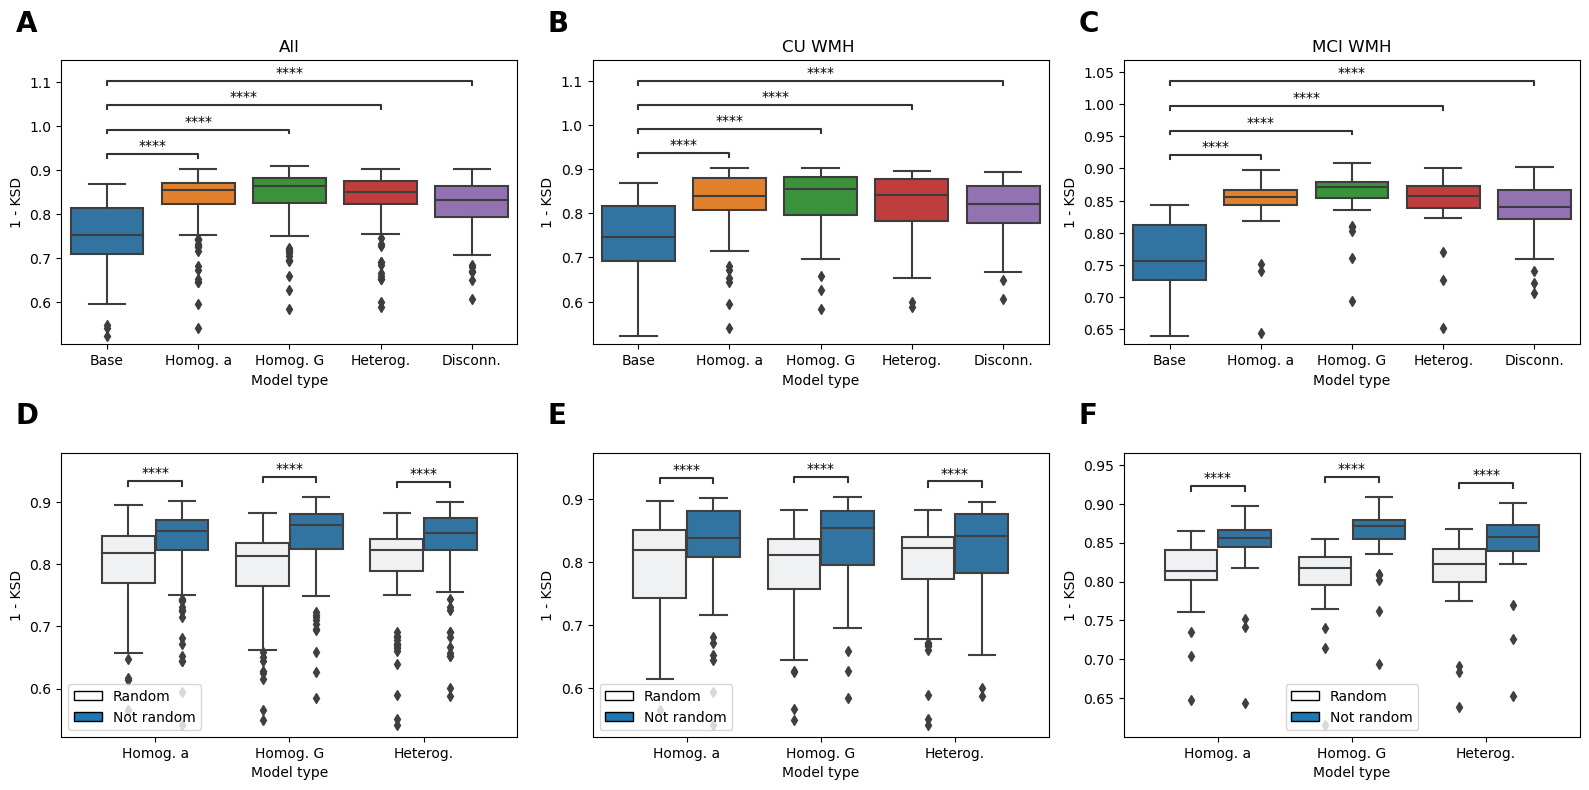

In [325]:
def plot_max_phfcd(group, df, df_compare_with_rand, axs):
    
    plot_obs(df, "phfcd_ks", axs[0])
    plot_random_comparison(
        df_compare_with_rand, "phfcd_ks", axs[1]
    )
    axs[0].set_xlabel("Model type")
    axs[0].set_ylabel("1 - KSD")
    axs[0].set_title(group)

# Plot the boxplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axs_col_one = axs[:, 0]
axs_col_two = axs[:, 1]
axs_col_three = axs[:, 2]
plot_max_phfcd("All", df_max_phfcd_merged, df_max_phfcd_compare_with_rand, axs_col_one)
plot_max_phfcd("CU WMH ", df_max_phfcd_cn, df_max_phfcd_cn_compare_with_rand, axs_col_two)
plot_max_phfcd("MCI WMH", df_max_phfcd_mci, df_max_phfcd_mci_compare_with_rand, axs_col_three)
write_figure_letters(axs)
fig.tight_layout()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

homogeneous_a_CN_WMH vs. homogeneous_a_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:2.598e-01 U_stat=7.540e+02
baseline_CN_WMH vs. baseline_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:5.881e-01 U_stat=8.210e+02
homogeneous_G_CN_WMH vs. homogeneous_G_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:1.495e-01 U_stat=7.180e+02
heterogeneous_CN_WMH vs. heterogeneous_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:1.785e-01 U_stat=7.290e+02
disconnectivity_CN_WMH vs. disconnectivity_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:2.022e-01 U_stat=7.370e+02


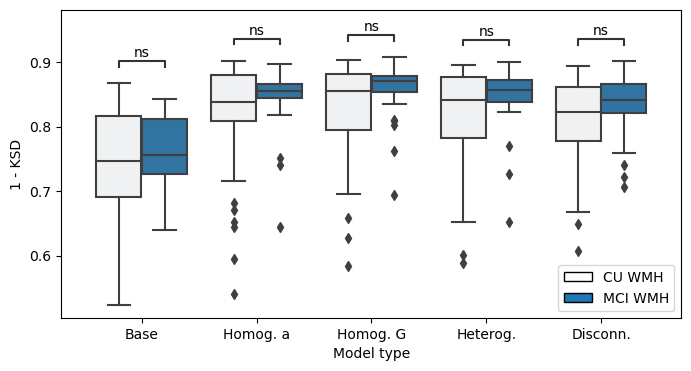

In [105]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 4))
plot_cn_mci_comparison("phfcd_ks", df_max_phfcd_merged, ax)

,Group,Slope,Intercept,R^2,p-value,Model,Parameter
0,All,0.025100,-0.023536,0.083137,0.006444,homogeneous_a,w_a
1,CU WMH,0.011521,-0.015474,0.020638,0.286372,homogeneous_a,w_a
2,MCI WMH,0.044694,-0.036225,0.222118,0.007445,homogeneous_a,w_a
0,All,-0.008671,-0.025644,0.035441,0.079000,homogeneous_a,a
1,CU WMH,-0.012869,-0.023851,0.055551,0.077567,homogeneous_a,a
2,MCI WMH,-0.003096,-0.028040,0.009981,0.592838,homogeneous_a,a


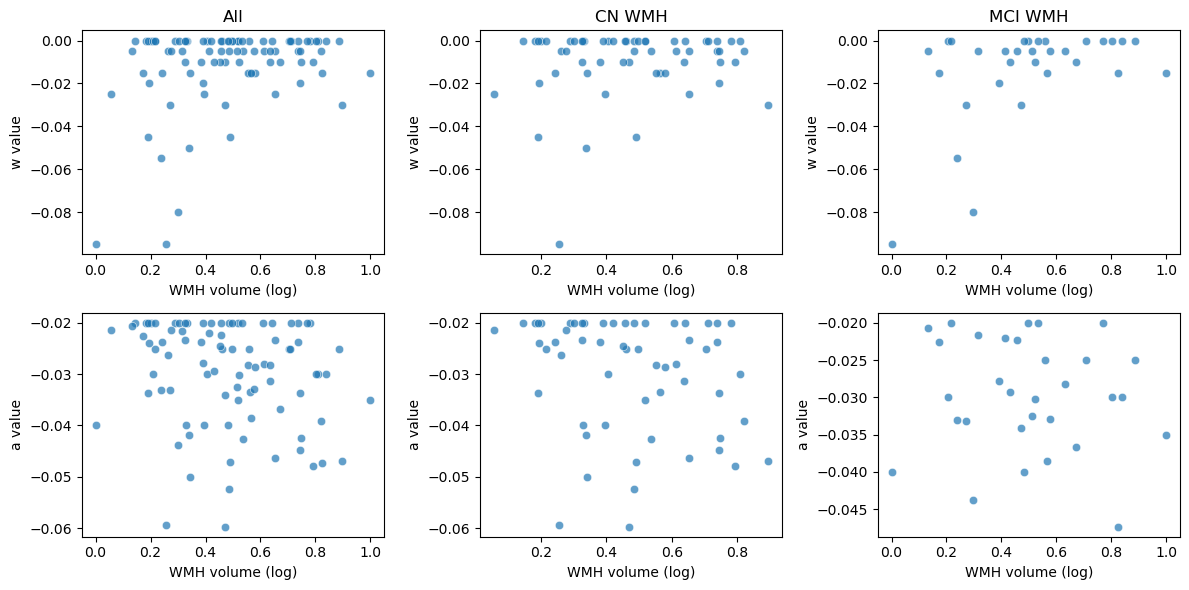

In [299]:
def plot_w_wmh_relationship(group, df, parm, ax):
    if parm == "a":
        color = "tab:blue"
    elif parm == "G":
        color = "tab:orange"
    if group == "All":
        sns.scatterplot(data = df, x = "wmh_load", y = "w", ax = ax[0], alpha = 0.7, color = color)
        # sns.scatterplot(data = df, x = "wmh_load", y = "b", label = "Bias", ax = ax)
        sns.scatterplot(data = df, x = "wmh_load", y = parm, ax = ax[1], alpha = 0.7, color = color)
        groupname = group
    else:
        groupname = f"{group.split('_')[0]} {group.split('_')[1]}"
        sns.scatterplot(data = df[df["Group_bin_Fazekas"] == group], x = "wmh_load", y = "w", ax = ax[0], alpha = 0.7, color = color)
        # sns.scatterplot(data = df[df["Group_bin_Fazekas"] == group], x = "wmh_load", y = "b", label = "Bias", ax = ax)
        sns.scatterplot(data = df[df["Group_bin_Fazekas"] == group], x = "wmh_load", y = parm, ax = ax[1], alpha = 0.7, color = color)
    ax[0].set_ylabel("w value")
    ax[1].set_ylabel(f"{parm} value")
    ax[0].set_xlabel("WMH volume (log)")
    ax[1].set_xlabel("WMH volume (log)")
    ax[0].set_title(groupname)

def lin_reg_wmh_parm(df, group, x, y):
    X = pd.to_numeric(df[x])
    Y = pd.to_numeric(df[y])
    # Use statsmodels to calculate p-values for the coefficients
    X_with_intercept = sm.add_constant(
        X
    )  # Add a constant (intercept) term to the features
    model = sm.OLS(
        Y, X_with_intercept
    ).fit()  # Fit an OLS (ordinary least squares) model
    # Get the coefficients (w) and intercept (b)
    lr_w = model.params[x]
    lr_b = model.params["const"]
    r2 = model.rsquared
    p = model.pvalues[x]

    return group, lr_w, lr_b, r2, p

def all_lin_reg_wmh_parm(model_type):
    parm = model_type[-1:]
    list_res_w = []
    list_res_parm = []
    list_df = [df_max_phfcd_merged, df_max_phfcd_cn, df_max_phfcd_mci]
    list_names = ["All", "CU WMH", "MCI WMH"]
    list_col_names = ["Group", "Slope", "Intercept", "R^2", "p-value"]
    for i, df in enumerate(list_df):
        list_res_w.append(lin_reg_wmh_parm(df[df["model_type"] == model_type], list_names[i], "wmh_load", "w"))
        list_res_parm.append(lin_reg_wmh_parm(df[df["model_type"] == model_type], list_names[i], "wmh_load", parm))

    df_res_w = pd.DataFrame(list_res_w, columns=list_col_names)
    df_res_parm = pd.DataFrame(list_res_parm, columns=list_col_names)
    df_res_w["Model"] = model_type
    df_res_parm["Model"] = model_type
    df_res_w["Parameter"] = "w_" + parm
    df_res_parm["Parameter"] = parm
    df_res = pd.concat([df_res_w, df_res_parm])
    return df_res

fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (12, 6))
axs_col_one = axs[:, 0]
axs_col_two = axs[:, 1]
axs_col_three = axs[:, 2]
plot_w_wmh_relationship("All", df_max_phfcd_merged[df_max_phfcd_merged["model_type"] == "homogeneous_a"], "a", axs_col_one)
plot_w_wmh_relationship("CN_WMH", df_max_phfcd_cn[df_max_phfcd_cn["model_type"] == "homogeneous_a"], "a", axs_col_two)
plot_w_wmh_relationship("MCI_WMH", df_max_phfcd_mci[df_max_phfcd_mci["model_type"] == "homogeneous_a"], "a", axs_col_three)
fig.tight_layout()

table_a = all_lin_reg_wmh_parm("homogeneous_a")
table_a

,Group,Weight,Bias,R^2,p-value,Model,Parameter
0,All,-0.042698,-0.469732,0.000788,0.795176,homogeneous_G,w_G
1,CU WMH,-0.079632,-0.442866,0.002188,0.729696,homogeneous_G,w_G
2,MCI WMH,0.014001,-0.515017,0.000129,0.951692,homogeneous_G,w_G
0,All,-0.522139,1.748429,0.129989,0.000559,homogeneous_G,G
1,CU WMH,-0.567970,1.797922,0.130770,0.005711,homogeneous_G,G
2,MCI WMH,-0.440646,1.657001,0.128281,0.047883,homogeneous_G,G


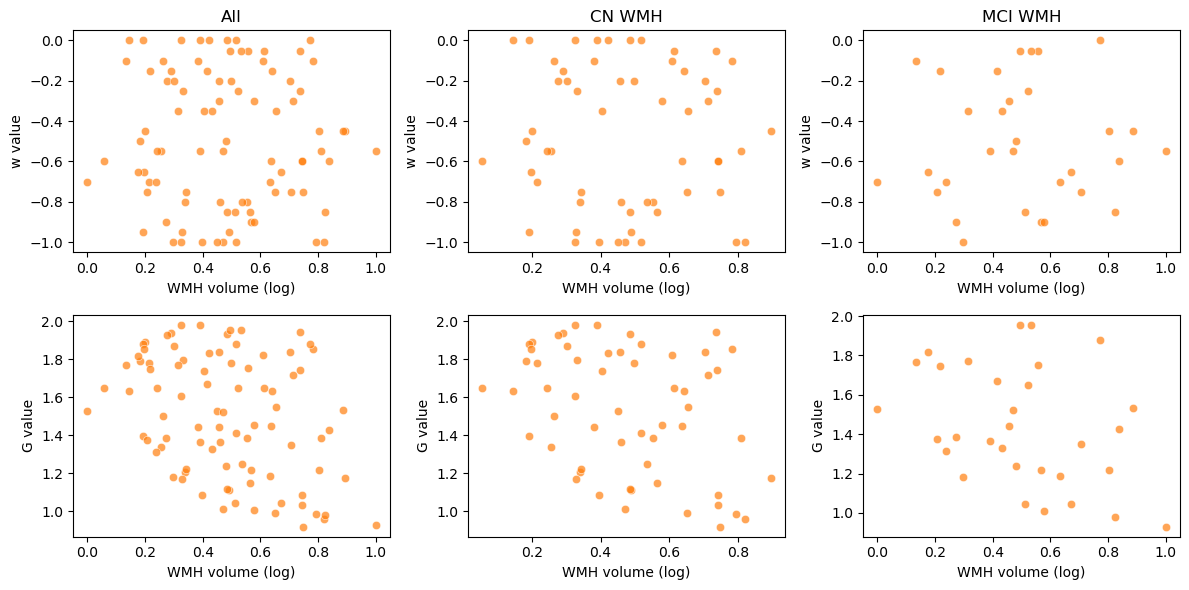

In [157]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize = (12, 6))
axs_col_one = axs[:, 0]
axs_col_two = axs[:, 1]
axs_col_three = axs[:, 2]
plot_w_wmh_relationship("All", df_max_phfcd_merged[df_max_phfcd_merged["model_type"] == "homogeneous_G"], "G", axs_col_one)
plot_w_wmh_relationship("CN_WMH", df_max_phfcd_cn[df_max_phfcd_cn["model_type"] == "homogeneous_G"], "G", axs_col_two)
plot_w_wmh_relationship("MCI_WMH", df_max_phfcd_mci[df_max_phfcd_mci["model_type"] == "homogeneous_G"], "G", axs_col_three)
fig.tight_layout()

table_G = all_lin_reg_wmh_parm("homogeneous_G")
table_G

In [ ]:
# assert (
#     df_a_big["PTID"].unique().shape[0]
#     & df_a_rand_big["PTID"].unique().shape[0]
#     & df_sc_big["PTID"].unique().shape[0]
#     & df_G_big["PTID"].unique().shape[0]
#     & df_G_rand_big["PTID"].unique().shape[0]
#     & df_het_big["PTID"].unique().shape[0]
#     & df_het_rand_big["PTID"].unique().shape[0]
#     & df_base["PTID"].unique().shape[0]
# ) == len(subjs_to_sim), "Something went wrong with loading"

# BEST AVERAGE analyses

In [303]:
def annotate_star(tbl):
    """
    This function is just to plot an asterisk at the best heatmap value for better recognition.
    """
    star = tbl.where(tbl == tbl.values.max())
    star = star.replace({np.nan: ""})
    star = star.replace({tbl.values.max(): "*"})
    return star

def create_pivot_tables(df_res):
    # Convert the result df into a pivot table so to plot heatmap
    table_phfcd = pd.pivot_table(
        df_res, values="phfcd_ks", index="b", columns="w"
    ).astype(float)
    return table_phfcd


def plot_save_heatmaps_group(group, table_phfcd, ax):
    """
    This function starts from the results dataframe, converts it into a pivot-table, which is what seaborn need to plot the heatmap.
    It does so both for fc and for phfcd. Also plots and saves the results.
    """
    
    sns.heatmap(
        ax=ax,
        data=table_phfcd,
        annot=annotate_star(table_phfcd),
        fmt="",
        annot_kws={"size": 10},
    )
    if group == "All":
        groupname = group
    elif group == "CN_WMH":
        groupname = "CU WMH"
    elif group == "MCI_WMH":
        groupname = "MCI WMH"
    ax.set_title(groupname)
    cbar = ax.collections[0].colorbar
    cbar.set_label('1 - KSD', rotation=270, labelpad=15)
    if group == "disconnectivity":
        ax.set_yticklabels([])  # Remove y-axis tick labels
        ax.set_ylabel("")  # Remove y-axis tick labels


def find_best_b_w_group(group, model, df_big):
    """
    This function calls the save_plot_results function, which plots and saves a summary heatmap of the mean FC and 1-phFCD across all patients that fall
    into a category (CN or MCI) according to the chosen grouping.

    Args:
        df_petTOAD:
        big_df:
        group:
        random:

    Returns:
        The b and ws associated with
    """
    if model == "disconnectivity":
        if group == "All":
            df = df_big.groupby(["w"]).mean(numeric_only = True)
        else:
            df = df_big[df_big["Group_bin_Fazekas"] == group].groupby(["w"]).mean(numeric_only = True)
        best_w = df.iloc[np.argmax(df["phfcd_ks"]), :].name
        tbl_phfcd = df[['phfcd_ks']].T

        print(f"The best parameters found for {group}, {model}:")
        print(f"w = {best_w}")
        return best_w, tbl_phfcd
    
    else:
        if group == "All":
            df = df_big.groupby(["b", "w"]).mean(numeric_only = True)
        else:   
            df = df_big[df_big["Group_bin_Fazekas"] == group].groupby(["b", "w"]).mean(numeric_only = True)            
        tbl_phfcd = create_pivot_tables(df)
        best_b = df.iloc[np.argmax(df["phfcd_ks"]), :].name[0]
        best_w = df.iloc[np.argmax(df["phfcd_ks"]), :].name[1]

    print(f"The best parameters found for {group}, {model}:")
    print(f"b = {best_b}, w = {best_w}")
    return best_b, best_w, tbl_phfcd

The best parameters found for All, homogeneous_a:
b = 0.0, w = -0.01
The best parameters found for CN_WMH, homogeneous_a:
b = 0.0, w = -0.01
The best parameters found for MCI_WMH, homogeneous_a:
b = -0.005, w = -0.005
The best parameters found for All, homogeneous_G:
b = -0.1, w = -0.7
The best parameters found for CN_WMH, homogeneous_G:
b = 0.0, w = -0.95
The best parameters found for MCI_WMH, homogeneous_G:
b = -0.1, w = -0.7
The best parameters found for All, heterogeneous:
b = 0.0, w = -0.015
The best parameters found for CN_WMH, heterogeneous:
b = 0.0, w = -0.015
The best parameters found for MCI_WMH, heterogeneous:
b = -0.005, w = 0.0
The best parameters found for All, disconnectivity:
w = 0.9
The best parameters found for CN_WMH, disconnectivity:
w = 0.97
The best parameters found for MCI_WMH, disconnectivity:
w = 0.98


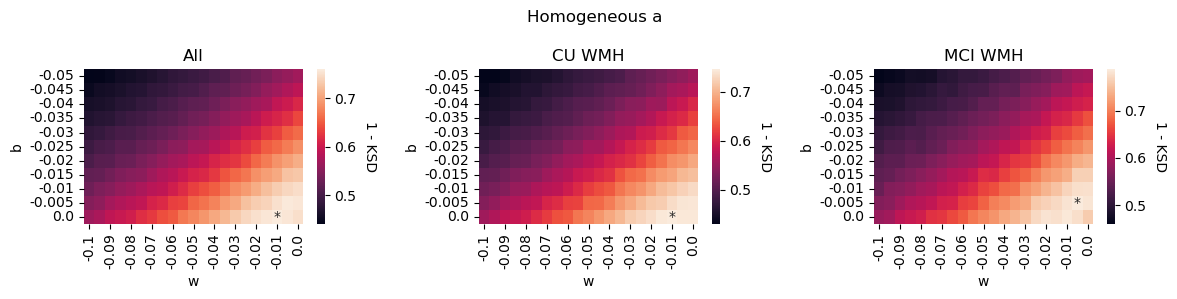

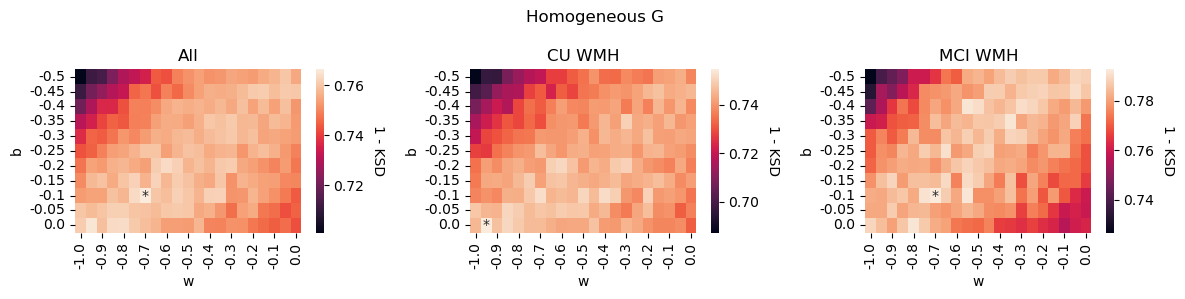

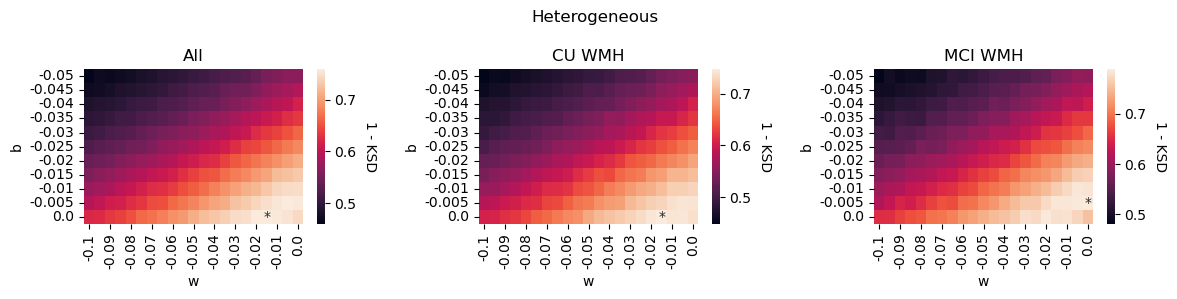

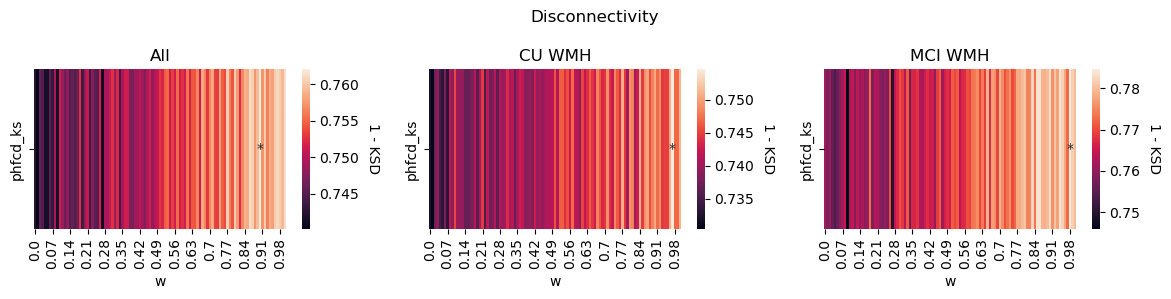

In [304]:
def get_best_b_w_group_and_save_plot(df_big, model):
    dict_title = {"homogeneous_a": "Homogeneous a",
                  "homogeneous_G": "Homogeneous G",
                  "heterogeneous": "Heterogeneous",
                  "disconnectivity": "Disconnectivity",
                  }
    
    if model == "disconnectivity":
        best_w_all, table_phfcd_all = find_best_b_w_group("All", model, df_big)
        best_w_cn, table_phfcd_cn = find_best_b_w_group("CN_WMH", model, df_big)
        best_w_mci, table_phfcd_mci = find_best_b_w_group("MCI_WMH", model, df_big)
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
        plot_save_heatmaps_group("All", table_phfcd_all, axs[0])
        plot_save_heatmaps_group("CN_WMH", table_phfcd_cn, axs[1])
        plot_save_heatmaps_group("MCI_WMH", table_phfcd_mci, axs[2])
        fig.suptitle(dict_title[model])
        fig.tight_layout()
        fig.savefig(FIG_DIR / f"group-all_model-{model}_desc-heatmap-best-average-w.png")
        return best_w_all, best_w_cn, best_w_mci

    else:
        best_b_all, best_w_all, table_phfcd_all = find_best_b_w_group("All", model, df_big)
        best_b_cn, best_w_cn, table_phfcd_cn = find_best_b_w_group("CN_WMH", model, df_big)
        best_b_mci, best_w_mci, table_phfcd_mci = find_best_b_w_group("MCI_WMH", model, df_big)
        fig, axs = plt.subplots(1, 3, figsize=(12, 3))
        plot_save_heatmaps_group("All", table_phfcd_all, axs[0])
        plot_save_heatmaps_group("CN_WMH", table_phfcd_cn, axs[1])
        plot_save_heatmaps_group("MCI_WMH", table_phfcd_mci, axs[2])
        fig.suptitle(dict_title[model])
        fig.tight_layout()
        fig.savefig(FIG_DIR / f"group-all_model-{model}_desc-heatmap-best-average-w-b.png")

        return best_b_all, best_w_all, best_b_cn, best_w_cn, best_b_mci, best_w_mci

best_b_all_a, best_w_all_a, best_b_cn_a, best_w_cn_a, best_b_mci_a, best_w_mci_a = get_best_b_w_group_and_save_plot(df_a_big, "homogeneous_a")
best_b_all_G, best_w_all_G, best_b_cn_G, best_w_cn_G, best_b_mci_G, best_w_mci_G = get_best_b_w_group_and_save_plot(df_G_big, "homogeneous_G")
best_b_all_het, best_w_all_het, best_b_cn_het, best_w_cn_het, best_b_mci_het, best_w_mci_het = get_best_b_w_group_and_save_plot(df_het_big, "heterogeneous")
best_w_all_disconn, best_w_cn_disconn, best_w_mci_disconn = get_best_b_w_group_and_save_plot(df_disconn_big, "disconnectivity")

In [ ]:
def select_b_w_combo(df_boxplot_long, w1, b1, w2, b2, groupname1, groupname2):
    compare_df1 = df_boxplot_long[
        (df_boxplot_long["w"] == w1) & (df_boxplot_long["b"] == b1)
    ]
    compare_df1 = compare_df1[compare_df1["group"] == groupname1]
    compare_df2 = df_boxplot_long[
        (df_boxplot_long["w"] == w2) & (df_boxplot_long["b"] == b2)
    ]
    compare_df2 = compare_df2[compare_df2["group"] == groupname2]
    joined_compare_df = pd.concat([compare_df1, compare_df2])
    return compare_df1, compare_df2, joined_compare_df

In [320]:
def create_df_boxplots(best_b_group_a, best_w_group_a,
                       best_b_group_G, best_w_group_G,
                       best_b_group_het, best_w_group_het,
                       best_w_group_disconn):
    # Set the random best to the same value as the non-random best
    best_b_a_rand, best_w_a_rand = best_b_group_a, best_w_group_a
    best_b_G_rand, best_w_G_rand = best_b_group_G, best_w_group_G
    best_b_het_rand, best_w_het_rand = best_b_group_het, best_w_group_het
    best_w_disconn_rand = best_w_group_disconn

    # Create df with only the best values from before for CN
    df_boxplot_compare_base = df_a_big[(df_a_big["b"] == 0) & (df_a_big["w"] == 0)].copy()
    df_boxplot_compare_a = df_a_big[(df_a_big["b"] == best_b_group_a) & (df_a_big["w"] == best_w_group_a)].copy()
    df_boxplot_compare_a_rand = df_a_rand_big[(df_a_rand_big["b"] == best_b_a_rand) & (df_a_rand_big["w"] == best_w_a_rand)].copy()
    df_boxplot_compare_G = df_G_big[(df_G_big["b"] == best_b_group_G) & (df_G_big["w"] == best_w_group_G)].copy()
    df_boxplot_compare_G_rand = df_G_rand_big[(df_G_rand_big["b"] == best_b_G_rand) & (df_G_rand_big["w"] == best_w_G_rand)].copy()
    df_boxplot_compare_het = df_het_big[(df_het_big["b"] == best_b_group_het) & (df_het_big["w"] == best_w_group_het)].copy()
    df_boxplot_compare_het_rand = df_het_rand_big[(df_het_rand_big["b"] == best_b_het_rand) & (df_het_rand_big["w"] == best_w_het_rand)].copy()
    df_boxplot_compare_disconn = df_disconn_big[df_disconn_big["w"] == best_w_group_disconn].copy()
    #df_boxplot_compare_disconn_rand = df_disconn_rand_big[df_disconn_big["w"] == best_w_disconn_rand].copy()

    df_boxplot_compare_base["model_type"] = "baseline"
    df_boxplot_compare_a_rand["model_type"] = "homogeneous_a"
    df_boxplot_compare_a_rand["random"] = "random"
    df_boxplot_compare_G_rand["model_type"] = "homogeneous_G"
    df_boxplot_compare_G_rand["random"] = "random"
    df_boxplot_compare_het_rand["model_type"] = "heterogeneous"
    df_boxplot_compare_het_rand["random"] = "random"
    #df_boxplot_compare_disconn_rand["model_type"] = "disconnectivity"
    #df_boxplot_compare_disconn_rand["random"] = "random"


    df_boxplot_compare = pd.concat(
        [
            df_boxplot_compare_base,
            df_boxplot_compare_a,
            df_boxplot_compare_G,
            df_boxplot_compare_het,
            df_boxplot_compare_disconn,
        ]
    )

    # Create a unified long df to compare the model performance between random vs. non-random
    df_boxplot_compare_rand = pd.concat(
        [
            df_boxplot_compare_a,
            df_boxplot_compare_a_rand,
            df_boxplot_compare_het,
            df_boxplot_compare_het_rand,
            df_boxplot_compare_G,
            df_boxplot_compare_G_rand,
        ]
    )
    return df_boxplot_compare, df_boxplot_compare_rand

df_boxplot_compare_all, df_boxplot_compare_rand_all = create_df_boxplots(best_b_all_a, best_w_all_a, best_b_all_G, best_w_all_G, best_b_all_het, best_w_all_het, best_w_all_disconn)
df_boxplot_compare_cn, df_boxplot_compare_rand_cn = create_df_boxplots(best_b_cn_a, best_w_cn_a, best_b_cn_G, best_w_cn_G, best_b_cn_het, best_w_cn_het, best_w_cn_disconn)
df_boxplot_compare_mci, df_boxplot_compare_rand_mci = create_df_boxplots(best_b_mci_a, best_w_mci_a, best_b_mci_G, best_w_mci_G, best_b_mci_het, best_w_mci_het, best_w_mci_disconn)

In [305]:
print("The best (b, w) for all subjects are as follows:")
print(f"Homogeneous a-weighted model: {best_b_all_a, best_w_all_a}")
print(f"Homogeneous G-weighted model: {best_b_all_G, best_w_all_G}")
print(f"Heterogeneous a-weighted model: {best_b_all_het, best_w_all_het}")
print("The best w for all subjects for the disconnectivity is as follows:")
print(f"{best_w_all_disconn}")
print("The best (b, w) for CN subjects are as follows:")
print(f"Homogeneous a-weighted model: {best_b_cn_a, best_w_cn_a}")
print(f"Homogeneous G-weighted model: {best_b_cn_G, best_w_cn_G}")
print(f"Heterogeneous a-weighted model: {best_b_cn_het, best_w_cn_het}")
print("The best w for CN subjects for the disconnectivity is as follows:")
print(f"{best_w_cn_disconn}")
print("######################################################################")
print("The best b and w for MCI subjects are as follows:")
print(f"Homogeneous a-weighted model: {best_b_mci_a, best_w_mci_a}")
print(f"Homogeneous G-weighted model: {best_b_mci_G, best_w_mci_G}")
print(f"Heterogeneous a-weighted model: {best_b_mci_het, best_w_mci_het}")
print("The best w for MCI subjects for the disconnectivity is as follows:")
print(f"{best_w_mci_disconn}")

dict_summary_best_w_b = {
    "": ["b", "w", "b", "w", "b", "w"],
    "Homogeneous a": [
        f"{best_b_all_a}",
        f"{best_b_all_a}",
        f"{best_b_cn_a}",
        f"{best_w_cn_a}",
        f"{best_b_mci_a}",
        f"{best_w_mci_a}",
    ],
    "Homogeneous G": [
        f"{best_b_all_G}",
        f"{best_w_all_G}",
        f"{best_b_cn_G}",
        f"{best_w_cn_G}",
        f"{best_b_mci_G}",
        f"{best_w_mci_G}",
    ],
    "Heterogeneous a": [
        f"{best_b_all_het}",
        f"{best_w_all_het}",
        f"{best_b_cn_het}",
        f"{best_w_cn_het}",
        f"{best_b_mci_het}",
        f"{best_w_mci_het}",
     ],
     "Disconnectivity": [
        "",
        f"{best_w_all_disconn}",
        "",
        f"{best_w_cn_disconn}",
        "",
        f"{best_w_mci_disconn}",
     ],
 }
df_summary_best_w_b = pd.DataFrame.from_dict(dict_summary_best_w_b).T
df_summary_best_w_b.columns = ["All", "", "CU WMH", "", "MCI WMH", ""]
#df_summary_best_w_b.to_csv(RES_DIR / "suppl_table2_best_b_w_group_level.csv")
df_summary_best_w_b

The best (b, w) for all subjects are as follows:
Homogeneous a-weighted model: (0.0, -0.01)
Homogeneous G-weighted model: (-0.1, -0.7)
Heterogeneous a-weighted model: (0.0, -0.015)
The best w for all subjects for the disconnectivity is as follows:
0.9
The best (b, w) for CN subjects are as follows:
Homogeneous a-weighted model: (0.0, -0.01)
Homogeneous G-weighted model: (0.0, -0.95)
Heterogeneous a-weighted model: (0.0, -0.015)
The best w for CN subjects for the disconnectivity is as follows:
0.97
######################################################################
The best b and w for MCI subjects are as follows:
Homogeneous a-weighted model: (-0.005, -0.005)
Homogeneous G-weighted model: (-0.1, -0.7)
Heterogeneous a-weighted model: (-0.005, 0.0)
The best w for MCI subjects for the disconnectivity is as follows:
0.98


,All,,CU WMH,,MCI WMH,
,b,w,b,w,b,w
Homogeneous a,0.0,0.0,0.0,-0.01,-0.005,-0.005
Homogeneous G,-0.1,-0.7,0.0,-0.95,-0.1,-0.7
Heterogeneous a,0.0,-0.015,0.0,-0.015,-0.005,0.0
Disconnectivity,,0.9,,0.97,,0.98


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

baseline vs. homogeneous_a: Wilcoxon test (paired samples), P_val:2.276e-01 Stat=1.668e+03
baseline vs. homogeneous_G: Wilcoxon test (paired samples), P_val:3.943e-02 Stat=1.463e+03
baseline vs. heterogeneous: Wilcoxon test (paired samples), P_val:1.985e-01 Stat=1.649e+03
baseline vs. disconnectivity: Wilcoxon test (paired samples), P_val:1.408e-01 Stat=1.604e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

homogeneous_G_random vs. homogeneous_G_not_random: Wilcoxon test (paired samples), P_val:4.147e-02 Stat=1.468e+03
homogeneous_a_random vs. homogeneous_a_not_random: Wilcoxon test (paired samples), P_val:5.630e-01 Stat=1.819e+03
heterogeneous_random v

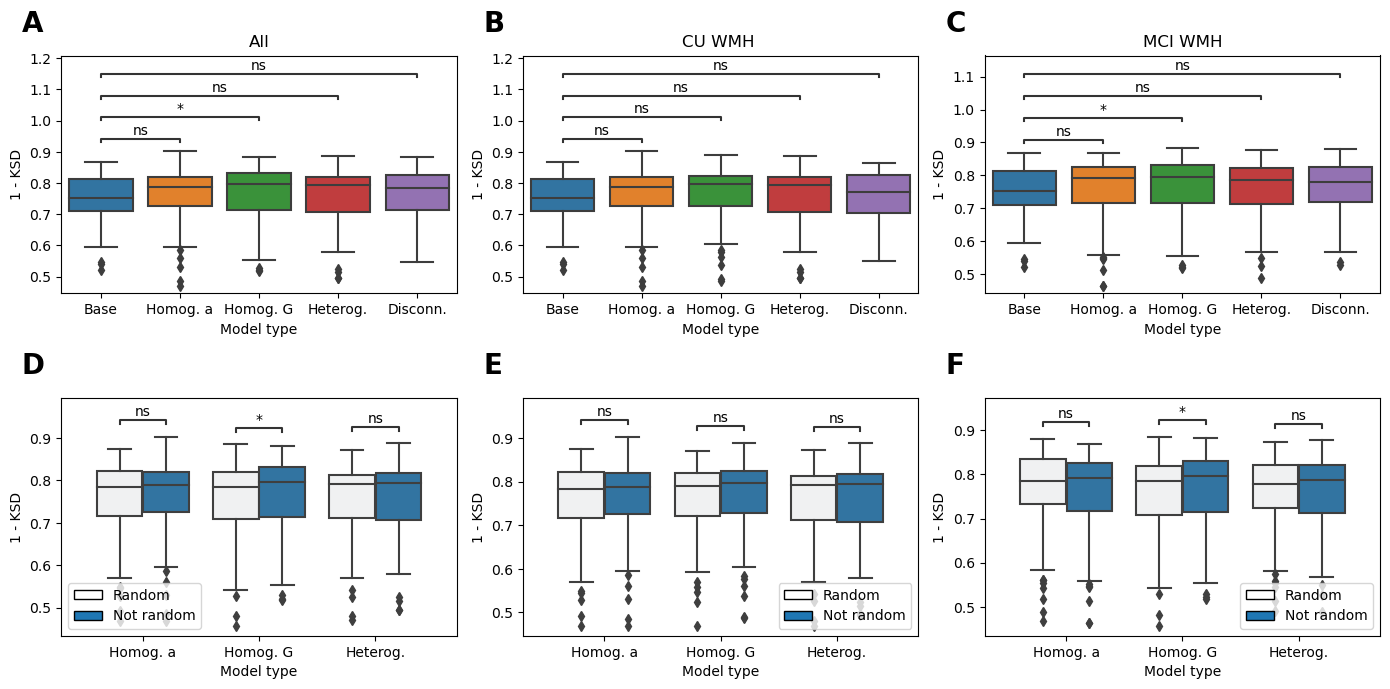

In [326]:
def plot_best_avg_phfcd(group, df, df_compare_with_rand, axs):
        
    plot_obs(df, "phfcd_ks", axs[0])
    plot_random_comparison(
        df_compare_with_rand, "phfcd_ks", axs[1]
    )
    axs[0].set_xlabel("Model type")
    axs[0].set_ylabel("1 - KSD")
    axs[0].set_title(group)

# Plot the boxplot
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(14, 7))
axs_col_one = axs[:, 0]
axs_col_two = axs[:, 1]
axs_col_three = axs[:, 2]
plot_best_avg_phfcd("All", df_boxplot_compare_all, df_boxplot_compare_rand_all, axs_col_one)
plot_best_avg_phfcd("CU WMH ", df_boxplot_compare_cn, df_boxplot_compare_rand_cn, axs_col_two)
plot_best_avg_phfcd("MCI WMH", df_boxplot_compare_mci, df_boxplot_compare_rand_mci, axs_col_three)
write_figure_letters(axs)
fig.tight_layout()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

homogeneous_a_CN_WMH vs. homogeneous_a_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:3.452e-02 U_stat=6.410e+02
baseline_CN_WMH vs. baseline_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:5.881e-01 U_stat=8.210e+02
homogeneous_G_CN_WMH vs. homogeneous_G_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:3.682e-02 U_stat=6.440e+02
heterogeneous_CN_WMH vs. heterogeneous_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:1.099e-01 U_stat=7.000e+02
disconnectivity_CN_WMH vs. disconnectivity_MCI_WMH: Mann-Whitney-Wilcoxon test two-sided, P_val:4.270e-02 U_stat=6.510e+02


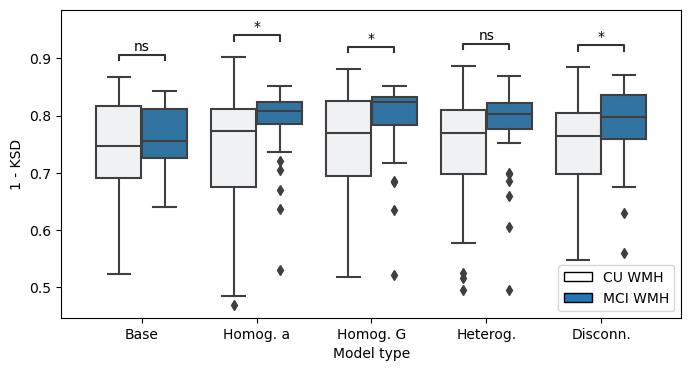

In [294]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (8, 4))
plot_cn_mci_comparison("phfcd_ks", df_boxplot_compare_all, ax)

# Analyses

## Summary statistics and tables

In [22]:
# Read in data
n_pts = len(df_petTOAD)
age_min = round(df_petTOAD.describe()["Age"]["min"], 0)
age_max = round(df_petTOAD.describe()["Age"]["max"], 0)
sex_counts = df_petTOAD["Sex"].value_counts()
DX_counts = df_petTOAD["Group"].value_counts()
females_num = sex_counts["F"]
males_num = sex_counts["M"]
cu_num = DX_counts["CN"]
mci_num = DX_counts["MCI"]

cu_no_wmh = len(df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_no_WMH"])
cu_wmh = len(df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"])
mci_no_wmh = len(df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_no_WMH"])
mci_wmh = len(df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"])

print(
    f"After exclusion, {n_pts} patients (age-range: {age_min}-{age_max}, {females_num} ({round(females_num / n_pts * 100, 2)}%) females, {males_num} ({round(males_num / n_pts * 100, 2)}%) males, {cu_num} ({round(cu_num / n_pts* 100, 1)}%) CU and {mci_num} ({round(mci_num / n_pts * 100, 1)}%) MCI) were considered for the modeling pipeline."
)
print(
    f"Patients were further subdivided into subgroups according to the previously defined Fazekas score cutoff of <= 2."
)
print(
    f"Accordingly, there were: {cu_no_wmh} ({round(cu_no_wmh / cu_num * 100, 1)}%) CU without WMH, {cu_wmh} ({round(cu_wmh / cu_num * 100, 1)}%) CU with WMH, {mci_no_wmh} ({round(mci_no_wmh / mci_num * 100, 1)}%) MCI without WMH, {mci_wmh} ({round(mci_wmh / mci_num* 100, 1)}%) MCI with WMH,"
)
# Create contingency table for comparing Fazekas binary classification between groups with Chi-squared
ct_wmh = pd.crosstab(df_petTOAD["WMH_bin"], df_petTOAD["Group"])
_, p_wmh, _, _ = stats.chi2_contingency(ct_wmh)
if p_wmh < 0.05:
    print(
        f"with statistically significant differences in frequency between subgroups (p = {round(p_wmh,3)})"
    )
else:
    print(
        f"with no statistically significant differences in frequency between subgroups (p = {round(p_wmh, 3)})"
    )
# Get age summary stats
age_summary = df_petTOAD.groupby(["Group"])["Age"].describe()
age_summary_subgroups = df_petTOAD.groupby(["Group_Fazekas_2.0"])["Age"].describe()
print("################# Results #################")
print("# Age #")
pval_age_diff_cn_vs_mci = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group"] == "CN"]["Age"],
    df_petTOAD[df_petTOAD["Group"] == "MCI"]["Age"],
)[1]
pval_age_diff_cn_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"]["Age"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_no_WMH"]["Age"],
)[1]
pval_age_diff_mci_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"]["Age"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_no_WMH"]["Age"],
)[1]
print(
    f"Median age for CU subjects = {age_summary['50%']['CN']} (IQR = {age_summary['25%']['CN']} - {age_summary['75%']['CN']})"
)
print(
    f"Median age for MCI subjects = {age_summary['50%']['MCI']} (IQR = {age_summary['25%']['MCI']} - {age_summary['75%']['MCI']})"
)
print(f"P-value age CU vs MCI: {round(pval_age_diff_cn_vs_mci, 5)}")

print(
    f"Median age for CU no WMH subjects = {age_summary_subgroups['50%']['CN_no_WMH']} (IQR = {age_summary_subgroups['25%']['CN_no_WMH']} - {age_summary_subgroups['75%']['CN_no_WMH']})"
)
print(
    f"Median age for CU WMH subjects = {age_summary_subgroups['50%']['CN_WMH']} (IQR = {age_summary_subgroups['25%']['CN_WMH']} - {age_summary_subgroups['75%']['CN_WMH']})"
)
print(f"P-value age CU no WMH vs CU WMH: {round(pval_age_diff_cn_no_wmh_vs_wmh, 5)}")

print(
    f"Median age for MCI no WMH subjects = {age_summary_subgroups['50%']['MCI_no_WMH']} (IQR = {age_summary_subgroups['25%']['MCI_no_WMH']} - {age_summary_subgroups['75%']['MCI_no_WMH']})"
)
print(
    f"Median age for MCI WMH subjects = {age_summary_subgroups['50%']['MCI_WMH']} (IQR = {age_summary_subgroups['25%']['MCI_WMH']} - {age_summary_subgroups['75%']['MCI_WMH']})"
)
print(f"P-value age MCI no WMH vs MCI WMH: {round(pval_age_diff_mci_no_wmh_vs_wmh, 5)}")


print("# WMH #")
wmh_summary = df_petTOAD.groupby(["Group"])["WMH_load_subj_space"].describe()
wmh_summary_subgroups = df_petTOAD.groupby(["Group_Fazekas_2.0"])[
    "WMH_load_subj_space"
].describe()

pval_wmh_diff_cn_vs_mci = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group"] == "CN"]["WMH_load_subj_space"],
    df_petTOAD[df_petTOAD["Group"] == "MCI"]["WMH_load_subj_space"],
)[1]
pval_wmh_diff_cn_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"]["WMH_load_subj_space"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_no_WMH"]["WMH_load_subj_space"],
)[1]
pval_wmh_diff_mci_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"]["WMH_load_subj_space"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_no_WMH"]["WMH_load_subj_space"],
)[1]

print(
    f"Median WMH volume load for CN subjects = {wmh_summary['50%']['CN']} (IQR = {wmh_summary['25%']['CN']} - {wmh_summary['75%']['CN']})"
)
print(
    f"Median WMH volume load for MCI subjects = {wmh_summary['50%']['MCI']} (IQR = {wmh_summary['25%']['MCI']} - {wmh_summary['75%']['MCI']})"
)
print(f"P-value WMH volum CU vs MCI: {pval_wmh_diff_cn_vs_mci}")

print(
    f"Median WMH volume load for CN no WMH subjects = {wmh_summary_subgroups['50%']['CN_no_WMH']} (IQR = {wmh_summary_subgroups['25%']['CN_no_WMH']} - {wmh_summary_subgroups['75%']['CN_no_WMH']})"
)
print(
    f"Median WMH volume load for CN WMH subjects = {wmh_summary_subgroups['50%']['CN_WMH']} (IQR = {wmh_summary_subgroups['25%']['CN_WMH']} - {wmh_summary_subgroups['75%']['CN_WMH']})"
)
print(f"P-value WMH volume CU no WMH vs CU WMH: {pval_wmh_diff_cn_no_wmh_vs_wmh}")

print(
    f"Median WMH volume load for MCI no WMH subjects = {wmh_summary_subgroups['50%']['MCI_no_WMH']} (IQR = {wmh_summary_subgroups['25%']['MCI_no_WMH']} - {wmh_summary_subgroups['75%']['MCI_no_WMH']})"
)
print(
    f"Median WMH volume load for MCI WMH subjects = {wmh_summary_subgroups['50%']['MCI_WMH']} (IQR = {wmh_summary_subgroups['25%']['MCI_WMH']} - {wmh_summary_subgroups['75%']['MCI_WMH']})"
)
print(f"P-value WMH volume MCI no WMH vs MCI WMH: {pval_wmh_diff_mci_no_wmh_vs_wmh}")

print("# MMSE #")
mmse_summary = df_petTOAD.groupby(["Group"])["MMSE"].describe()
mmse_summary_subgroups = df_petTOAD.groupby(["Group_Fazekas_2.0"])["MMSE"].describe()

pval_mmse_diff_cn_vs_mci = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group"] == "CN"]["MMSE"],
    df_petTOAD[df_petTOAD["Group"] == "MCI"]["MMSE"],
)[1]
pval_mmse_diff_cn_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"]["MMSE"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_no_WMH"]["MMSE"],
)[1]
pval_mmse_diff_mci_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"]["MMSE"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_no_WMH"]["MMSE"],
)[1]

print(
    f"Median MMSE score for CN subjects = {mmse_summary['50%']['CN']} (IQR = {mmse_summary['25%']['CN']} - {mmse_summary['75%']['CN']})"
)
print(
    f"Median MMSE score for MCI subjects = {mmse_summary['50%']['MCI']} (IQR = {mmse_summary['25%']['MCI']} - {mmse_summary['75%']['MCI']})"
)
print(f"P-value MMSE score CU vs MCI: {pval_mmse_diff_cn_vs_mci}")

print(
    f"Median MMSE score for CN no WMH subjects = {mmse_summary_subgroups['50%']['CN_no_WMH']} (IQR = {mmse_summary_subgroups['25%']['CN_no_WMH']} - {mmse_summary_subgroups['75%']['CN_no_WMH']})"
)
print(
    f"Median MMSE score for CN WMH subjects = {mmse_summary_subgroups['50%']['CN_WMH']} (IQR = {mmse_summary_subgroups['25%']['CN_WMH']} - {mmse_summary_subgroups['75%']['CN_WMH']})"
)
print(f"P-value MMSE score CU no WMH vs CU WMH: {pval_mmse_diff_cn_no_wmh_vs_wmh}")

print(
    f"Median MMSE score for MCI no WMH subjects = {mmse_summary_subgroups['50%']['MCI_no_WMH']} (IQR = {mmse_summary_subgroups['25%']['MCI_no_WMH']} - {mmse_summary_subgroups['75%']['MCI_no_WMH']})"
)
print(
    f"Median MMSE score for MCI WMH subjects = {mmse_summary_subgroups['50%']['MCI_WMH']} (IQR = {mmse_summary_subgroups['25%']['MCI_WMH']} - {mmse_summary_subgroups['75%']['MCI_WMH']})"
)
print(f"P-value MMSE score MCI no WMH vs MCI WMH: {pval_mmse_diff_mci_no_wmh_vs_wmh}")

print("# Education #")
educ_summary = df_petTOAD.groupby(["Group"])["PTEDUCAT"].describe()
educ_summary_subgroups = df_petTOAD.groupby(["Group_Fazekas_2.0"])[
    "PTEDUCAT"
].describe()

pval_educ_diff_cn_vs_mci = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group"] == "CN"]["PTEDUCAT"],
    df_petTOAD[df_petTOAD["Group"] == "MCI"]["PTEDUCAT"],
)[1]
pval_educ_diff_cn_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_WMH"]["PTEDUCAT"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "CN_no_WMH"]["PTEDUCAT"],
)[1]
pval_educ_diff_mci_no_wmh_vs_wmh = stats.mannwhitneyu(
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_WMH"]["PTEDUCAT"],
    df_petTOAD[df_petTOAD["Group_Fazekas_2.0"] == "MCI_no_WMH"]["PTEDUCAT"],
)[1]

print(
    f"Median MMSE score for CN subjects = {educ_summary['50%']['CN']} (IQR = {educ_summary['25%']['CN']} - {educ_summary['75%']['CN']})"
)
print(
    f"Median MMSE score for MCI subjects = {educ_summary['50%']['MCI']} (IQR = {educ_summary['25%']['MCI']} - {educ_summary['75%']['MCI']})"
)
print(f"P-value MMSE score CU vs MCI: {pval_educ_diff_cn_vs_mci}")

print(
    f"Median MMSE score for CN no WMH subjects = {educ_summary_subgroups['50%']['CN_no_WMH']} (IQR = {educ_summary_subgroups['25%']['CN_no_WMH']} - {educ_summary_subgroups['75%']['CN_no_WMH']})"
)
print(
    f"Median MMSE score for CN WMH subjects = {educ_summary_subgroups['50%']['CN_WMH']} (IQR = {educ_summary_subgroups['25%']['CN_WMH']} - {educ_summary_subgroups['75%']['CN_WMH']})"
)
print(f"P-value MMSE score CU no WMH vs CU WMH: {pval_educ_diff_cn_no_wmh_vs_wmh}")

print(
    f"Median MMSE score for MCI no WMH subjects = {educ_summary_subgroups['50%']['MCI_no_WMH']} (IQR = {educ_summary_subgroups['25%']['MCI_no_WMH']} - {educ_summary_subgroups['75%']['MCI_no_WMH']})"
)
print(
    f"Median MMSE score for MCI WMH subjects = {educ_summary_subgroups['50%']['MCI_WMH']} (IQR = {educ_summary_subgroups['25%']['MCI_WMH']} - {educ_summary_subgroups['75%']['MCI_WMH']})"
)
print(f"P-value MMSE score MCI no WMH vs MCI WMH: {pval_educ_diff_mci_no_wmh_vs_wmh}")


print("# Sex #")
# Create contingency table for chi-squared
ct_sex = pd.crosstab(df_petTOAD["Sex"], df_petTOAD["Group"])
c_sex, p_sex, _, _ = stats.chi2_contingency(ct_sex)
if p_sex < 0.05:
    print(
        f"MCI and CU showed statistically significant sex differences, p = {round(p_sex, 3)}"
    )
else:
    print(f"MCI and CU showed no sex groups differences, p = {round(p_sex,3)}")

# Create contingency table for chi-squared
ct_sex_wmh = pd.crosstab(df_petTOAD["Sex"], df_petTOAD["Group_Fazekas_2.0"])
ct_sex_cn = ct_sex_wmh.iloc[:2, :2]
c_sex_cn, p_sex_cn, _, _ = stats.chi2_contingency(ct_sex_cn)
if p_sex_cn < 0.05:
    print(
        f"CU WMH and CU no WMH showed statistically significant sex differences, p = {round(p_sex_cn, 3)}"
    )
else:
    print(
        f"CU WMH and CU no WMH showed no sex groups differences, p = {round(p_sex_cn,3)}"
    )

# Create contingency table for chi-squared
ct_sex_mci = ct_sex_wmh.iloc[:2, 2:]
c_sex_mci, p_sex_mci, _, _ = stats.chi2_contingency(ct_sex_mci)
if p_sex_mci < 0.05:
    print(
        f"CU WMH and CU no WMH showed statistically significant sex differences, p = {round(p_sex_mci, 3)}"
    )
else:
    print(
        f"MCI WMH and MCI no WMH showed no sex groups differences, p = {round(p_sex_mci,3)}"
    )

After exclusion, 188 patients (age-range: 56.0-90.0, 101 (53.72%) females, 87 (46.28%) males, 120 (63.8%) CU and 68 (36.2%) MCI) were considered for the modeling pipeline.
Patients were further subdivided into subgroups according to the previously defined Fazekas score cutoff of <= 2.
Accordingly, there were: 63 (52.5%) CU without WMH, 57 (47.5%) CU with WMH, 37 (54.4%) MCI without WMH, 31 (45.6%) MCI with WMH,
with no statistically significant differences in frequency between subgroups (p = 0.92)
################# Results #################
# Age #
Median age for CU subjects = 69.5 (IQR = 66.0 - 76.0)
Median age for MCI subjects = 72.0 (IQR = 68.75 - 79.0)
P-value age CU vs MCI: 0.03996
Median age for CU no WMH subjects = 68.0 (IQR = 66.0 - 71.5)
Median age for CU WMH subjects = 73.0 (IQR = 68.0 - 77.0)
P-value age CU no WMH vs CU WMH: 0.00055
Median age for MCI no WMH subjects = 71.0 (IQR = 65.0 - 76.0)
Median age for MCI WMH subjects = 76.0 (IQR = 71.5 - 79.5)
P-value age MCI no WMH 

In [23]:
# Create a summary DataFrame
summary_data = {
    "Age Median (IQR)": [
        f"{age_summary['50%']['CN']} ({age_summary['25%']['CN']} - {age_summary['75%']['CN']})",
        f"{age_summary['50%']['MCI']} ({age_summary['25%']['MCI']} - {age_summary['75%']['MCI']})",
        f"{round(pval_age_diff_cn_vs_mci, 4)}",
    ],
    "Sex n (%)": ["", "", round(p_sex, 3)],
    "Woman": [
        f"{ct_sex.iloc[0, 0]} ({round(ct_sex.iloc[0, 0]/cu_num * 100, 1)}%)",
        f"{ct_sex.iloc[0, 1]} ({round(ct_sex.iloc[0, 1] / mci_num * 100, 1)}%)",
        "",
    ],
    "Man": [
        f"{ct_sex.iloc[1, 0]} ({round(ct_sex.iloc[1, 0]/cu_num * 100, 1)}%)",
        f"{ct_sex.iloc[1, 1]} ({round(ct_sex.iloc[1, 1] / mci_num * 100, 1)}%)",
        "",
    ],
    "WMH volume (mm^3)": [
        f"{int(wmh_summary['50%']['CN'])} ({int(wmh_summary['25%']['CN'])}-{int(wmh_summary['75%']['CN'])})",
        f"{int(wmh_summary['50%']['MCI'])} ({int(wmh_summary['25%']['MCI'])}-{int(wmh_summary['75%']['MCI'])})",
        f"{round(pval_wmh_diff_cn_vs_mci, 3)}",
    ],
    "Fazekas score binned n (%)": ["", "", round(p_wmh, 3)],
    "WMH": [
        f"{ct_wmh.iloc[0, 0]} ({round(ct_wmh.iloc[0, 0]/cu_num * 100, 1)}%)",
        f"{ct_wmh.iloc[0, 1]} ({round(ct_wmh.iloc[0, 1] / mci_num * 100, 1)}%)",
        "",
    ],
    "no WMH": [
        f"{ct_wmh.iloc[1, 0]} ({round(ct_wmh.iloc[1, 0]/cu_num * 100, 1)}%)",
        f"{ct_wmh.iloc[1, 1]} ({round(ct_wmh.iloc[1, 1] / mci_num * 100, 1)}%)",
        "",
    ],
}

# Create the summary DataFrame
df_summary = pd.DataFrame(data=summary_data)

# Print the summary DataFrame
df_table1_bis = df_summary.T
df_table1_bis.columns = [f"CU, n = {cu_num}", f"MCI, n = {mci_num}", "p-value"]
#df_table1_bis.to_csv(RES_DIR / "table_1_group_together.csv")
df_table1_bis

,"CU, n = 120","MCI, n = 68",p-value
Age Median (IQR),69.5 (66.0 - 76.0),72.0 (68.75 - 79.0),0.04
Sex n (%),,,0.014
Woman,73 (60.8%),28 (41.2%),
Man,47 (39.2%),40 (58.8%),
WMH volume (mm^3),4686 (2054-11644),4524 (2294-12377),0.629
Fazekas score binned n (%),,,0.92
WMH,57 (47.5%),31 (45.6%),
no WMH,63 (52.5%),37 (54.4%),


In [24]:
# Create a summary DataFrame
summary_data = {
    "Age Median (IQR)": [
        f"{age_summary_subgroups['50%']['CN_no_WMH']} ({age_summary_subgroups['25%']['CN_no_WMH']} - {age_summary_subgroups['75%']['CN_no_WMH']})",
        f"{age_summary_subgroups['50%']['CN_WMH']} ({age_summary_subgroups['25%']['CN_WMH']} - {age_summary_subgroups['75%']['CN_WMH']})",
        f"{round(pval_age_diff_cn_no_wmh_vs_wmh, 3)}",
        f"{age_summary_subgroups['50%']['MCI_no_WMH']} ({age_summary_subgroups['25%']['MCI_no_WMH']} - {age_summary_subgroups['75%']['MCI_no_WMH']})",
        f"{age_summary_subgroups['50%']['MCI_WMH']} ({age_summary_subgroups['25%']['MCI_WMH']} - {age_summary_subgroups['75%']['MCI_WMH']})",
        f"{round(pval_age_diff_mci_no_wmh_vs_wmh, 3)}",
    ],
    "Sex n (%)": ["", "", round(p_sex_cn, 3), "", "", round(p_sex_mci)],
    "Woman": [
        f"{ct_sex_cn['CN_no_WMH']['F']} ({round(ct_sex_cn['CN_no_WMH']['F'] / ct_sex_cn['CN_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_cn['CN_WMH']['F']} ({round(ct_sex_cn['CN_WMH']['F'] / ct_sex_cn['CN_WMH'].sum() * 100, 1)}%)",
        " ",
        f"{ct_sex_mci['MCI_no_WMH']['F']} ({round(ct_sex_mci['MCI_no_WMH']['F'] / ct_sex_mci['MCI_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_mci['MCI_WMH']['F']} ({round(ct_sex_mci['MCI_WMH']['F'] / ct_sex_mci['MCI_WMH'].sum() * 100, 1)}%)",
        " ",
    ],
    "Man": [
        f"{ct_sex_cn['CN_no_WMH']['M']} ({round(ct_sex_cn['CN_no_WMH']['M'] / ct_sex_cn['CN_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_cn['CN_WMH']['M']} ({round(ct_sex_cn['CN_WMH']['M'] / ct_sex_cn['CN_WMH'].sum() * 100, 1)}%)",
        " ",
        f"{ct_sex_mci['MCI_no_WMH']['M']} ({round(ct_sex_mci['MCI_no_WMH']['M'] / ct_sex_mci['MCI_no_WMH'].sum() * 100, 1)}%)",
        f"{ct_sex_mci['MCI_WMH']['M']} ({round(ct_sex_mci['MCI_WMH']['M'] / ct_sex_mci['MCI_WMH'].sum() * 100, 1)}%)",
        " ",
    ],
    "WMH volume (mm^3)": [
        f"{int(wmh_summary_subgroups['50%']['CN_no_WMH'])} ({int(wmh_summary_subgroups['25%']['CN_no_WMH'])}-{int(wmh_summary_subgroups['75%']['CN_no_WMH'])})",
        f"{int(wmh_summary_subgroups['50%']['CN_WMH'])} ({int(wmh_summary_subgroups['25%']['CN_WMH'])}-{int(wmh_summary_subgroups['75%']['CN_WMH'])})",
        f"{round(pval_wmh_diff_cn_no_wmh_vs_wmh, 20)}",
        f"{int(wmh_summary_subgroups['50%']['MCI_no_WMH'])} ({int(wmh_summary_subgroups['25%']['MCI_no_WMH'])}-{int(wmh_summary_subgroups['75%']['MCI_no_WMH'])})",
        f"{int(wmh_summary_subgroups['50%']['MCI_WMH'])} ({int(wmh_summary_subgroups['25%']['MCI_WMH'])}-{int(wmh_summary_subgroups['75%']['MCI_WMH'])})",
        f"{round(pval_wmh_diff_mci_no_wmh_vs_wmh, 20)}",
    ],
    "MMSE": [
        f"{int(mmse_summary_subgroups['50%']['CN_no_WMH'])} ({int(mmse_summary_subgroups['25%']['CN_no_WMH'])}-{int(mmse_summary_subgroups['75%']['CN_no_WMH'])})",
        f"{int(mmse_summary_subgroups['50%']['CN_WMH'])} ({int(mmse_summary_subgroups['25%']['CN_WMH'])}-{int(mmse_summary_subgroups['75%']['CN_WMH'])})",
        f"{round(pval_mmse_diff_cn_no_wmh_vs_wmh, 2)}",
        f"{int(mmse_summary_subgroups['50%']['MCI_no_WMH'])} ({int(mmse_summary_subgroups['25%']['MCI_no_WMH'])}-{int(mmse_summary_subgroups['75%']['MCI_no_WMH'])})",
        f"{int(mmse_summary_subgroups['50%']['MCI_WMH'])} ({int(mmse_summary_subgroups['25%']['MCI_WMH'])}-{int(mmse_summary_subgroups['75%']['MCI_WMH'])})",
        f"{round(pval_mmse_diff_mci_no_wmh_vs_wmh, 2)}",
    ],
    "Education (yrs)": [
        f"{int(educ_summary_subgroups['50%']['CN_no_WMH'])} ({int(educ_summary_subgroups['25%']['CN_no_WMH'])}-{int(educ_summary_subgroups['75%']['CN_no_WMH'])})",
        f"{int(educ_summary_subgroups['50%']['CN_WMH'])} ({int(educ_summary_subgroups['25%']['CN_WMH'])}-{int(educ_summary_subgroups['75%']['CN_WMH'])})",
        f"{round(pval_educ_diff_cn_no_wmh_vs_wmh, 2)}",
        f"{int(educ_summary_subgroups['50%']['MCI_no_WMH'])} ({int(educ_summary_subgroups['25%']['MCI_no_WMH'])}-{int(educ_summary_subgroups['75%']['MCI_no_WMH'])})",
        f"{int(educ_summary_subgroups['50%']['MCI_WMH'])} ({int(educ_summary_subgroups['25%']['MCI_WMH'])}-{int(educ_summary_subgroups['75%']['MCI_WMH'])})",
        f"{round(pval_educ_diff_mci_no_wmh_vs_wmh, 2)}",
    ],
}

# Create the summary DataFrame
df_summary = pd.DataFrame(data=summary_data)

# Print the summary DataFrame
df_table1 = df_summary.T
df_table1.columns = [
    f"CU no WMH (n = {cu_no_wmh})",
    f"CU WMH (n = {cu_wmh})",
    "p",
    f"MCI no WMH (n = {mci_no_wmh})",
    f"MCI WMH (n = {mci_wmh})",
    "p-val",
]
#df_table1.to_csv(RES_DIR / "table_1.csv")
df_table1

,CU no WMH (n = 63),CU WMH (n = 57),p,MCI no WMH (n = 37),MCI WMH (n = 31),p-val
Age Median (IQR),68.0 (66.0 - 71.5),73.0 (68.0 - 77.0),0.001,71.0 (65.0 - 76.0),76.0 (71.5 - 79.5),0.003
Sex n (%),,,0.494,,,1
Woman,36 (57.1%),37 (64.9%),,15 (40.5%),13 (41.9%),
Man,27 (42.9%),20 (35.1%),,22 (59.5%),18 (58.1%),
WMH volume (mm^3),2083 (912-3446),12202 (6950-23818),1.507e-17,2456 (1629-4416),13519 (6451-24825),2.17188538875e-09
MMSE,29 (29-30),29 (29-30),0.47,29 (28-29),28 (27-29),0.52
Education (yrs),18 (16-18),16 (14-18),0.06,16 (15-18),16 (15-18),0.96


## Figures 

Text(-0.1, 1.1, 'B')

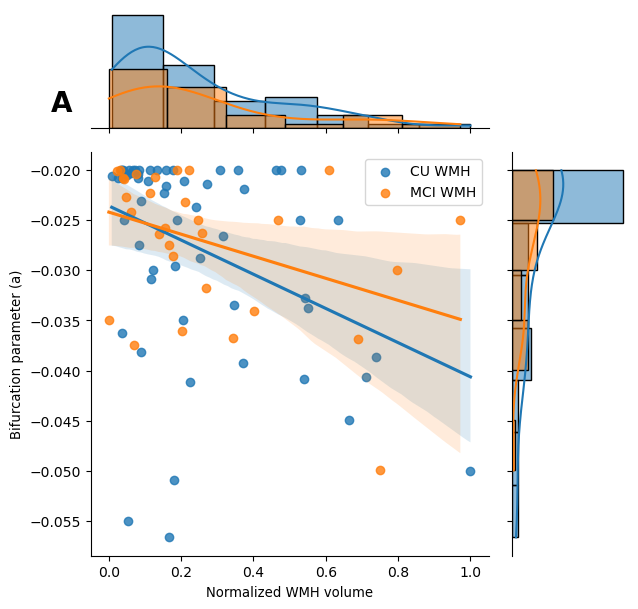

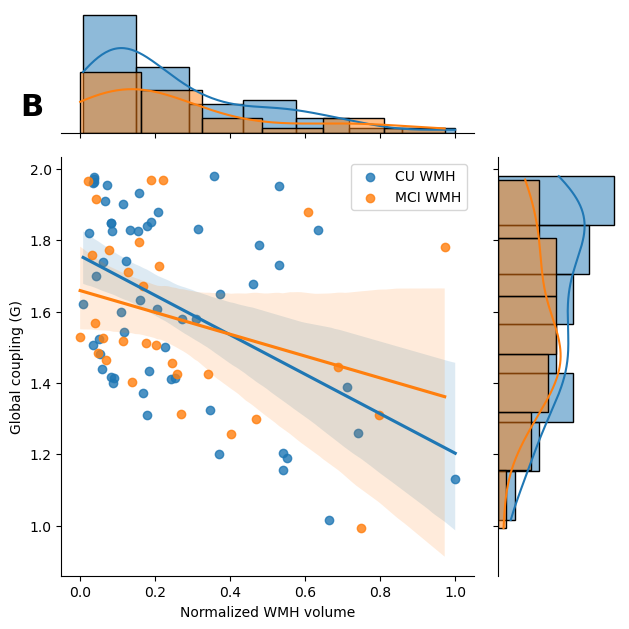

In [37]:
# Create a JointGrid for the scatter plots and histograms
grid1 = sns.JointGrid(height=6, ratio=3)

# Plot the scatter plots on the grid
sns.regplot(
    data=df_max_comp_score_a_cn, x="wmh_load", y="a", ax=grid1.ax_joint, label="CU WMH"
)
sns.regplot(
    data=df_max_comp_score_a_mci,
    x="wmh_load",
    y="a",
    ax=grid1.ax_joint,
    label="MCI WMH",
)

# Plot histograms on the top and left sides of the grid
sns.histplot(data=df_max_comp_score_a_cn, x="wmh_load", ax=grid1.ax_marg_x, kde=True)
sns.histplot(
    data=df_max_comp_score_a_mci,
    x="wmh_load",
    ax=grid1.ax_marg_x,
    kde=True,
    color="tab:orange",
)
sns.histplot(data=df_max_comp_score_a_cn, y="a", ax=grid1.ax_marg_y, kde=True)
sns.histplot(
    data=df_max_comp_score_a_mci,
    y="a",
    ax=grid1.ax_marg_y,
    kde=True,
    color="tab:orange",
)

# Set labels for the scatter plot and legends
grid1.set_axis_labels(
    "Normalized WMH volume", "Bifurcation parameter (a)", fontsize=9.5
)
grid1.ax_joint.legend()
ax1 = grid1.fig.axes[0]
ax1.text(-0.1, 1.1, "A", transform=ax1.transAxes, size=20, weight="bold")


# Create a JointGrid for the scatter plots and histograms
grid2 = sns.JointGrid(height=6.2, ratio=3)

# Plot the scatter plots on the grid
sns.regplot(
    data=df_max_comp_score_G_cn, x="wmh_load", y="G", ax=grid2.ax_joint, label="CU WMH"
)
sns.regplot(
    data=df_max_comp_score_G_mci,
    x="wmh_load",
    y="G",
    ax=grid2.ax_joint,
    label="MCI WMH",
)

# Plot histograms on the top and left sides of the grid
sns.histplot(data=df_max_comp_score_G_cn, x="wmh_load", ax=grid2.ax_marg_x, kde=True)
sns.histplot(
    data=df_max_comp_score_G_mci,
    x="wmh_load",
    ax=grid2.ax_marg_x,
    kde=True,
    color="tab:orange",
)
sns.histplot(data=df_max_comp_score_G_cn, y="G", ax=grid2.ax_marg_y, kde=True)
sns.histplot(
    data=df_max_comp_score_G_mci,
    y="G",
    ax=grid2.ax_marg_y,
    kde=True,
    color="tab:orange",
)

# Set labels for the scatter plot and legends
grid2.set_axis_labels("Normalized WMH volume", "Global coupling (G)", fontsize=10)
grid2.ax_joint.legend()
ax2 = grid2.fig.axes[0]
ax2.text(-0.1, 1.1, "B", transform=ax2.transAxes, size=22, weight="bold")

## Supplementary

### Supplementary Tables

In [34]:
from itertools import combinations

def results_combo(df, all_pairs, rand=False):
    # Create a dictionary to store the results
    results = {}
    # Loop through the pairs and perform wilcoxon test to see if model performance is different among all possible pairs
    for pair in all_pairs:
        group1 = df[df["Model_type"] == pair[0]]
        group2 = df[df["Model_type"] == pair[1]]
        # Note: Reported as Wilcoxon T test since Scipy.stats.wilcoxon() method reports the T value and not the W value
        t_statistic_comp_score, p_value_comp_score = stats.wilcoxon(
            group1["comp_score"], group2["comp_score"]
        )
        # Save everything in a results dictionary
        results[f"{pair[0]} vs {pair[1]}"] = {
            "t_statistic_comp_score": t_statistic_comp_score,
            "p_value_comp_score": p_value_comp_score,
        }

    return results

# Use itertools.combinations to create a combination of all model types (same for CN and MCI)
model_pairs = list(combinations(df_max_comp_score_CN["Model_type"].unique(), 2))

# Perform all the comparisons both for CU with WMH and for MCI with WMH for non-random vs. baseline and vs. one another...
results_pairs_cn = results_combo(df_max_comp_score_CN, model_pairs, rand=False)
results_pairs_mci = results_combo(df_max_comp_score_mci, model_pairs, rand=False)
# Store everythin in dataframes
df_results_pairs_cn = pd.DataFrame().from_dict(results_pairs_cn).T
df_results_pairs_mci = pd.DataFrame().from_dict(results_pairs_mci).T

# Now we create a summary dataset with quartiles and median for the different observables for CU WMH
df_describe_model_fit_cn_wmh = round(
    df_max_comp_score_CN.groupby("Model_type").describe()[
        [
            ("comp_score", "25%"),
            ("comp_score", "50%"),
            ("comp_score", "75%"),
        ]
    ],
    3,
)
# ... and for MCI WMH
df_describe_model_fit_mci_wmh = round(
    df_max_comp_score_mci.groupby("Model_type").describe()[
        [
            ("comp_score", "25%"),
            ("comp_score", "50%"),
            ("comp_score", "75%"),
        ]
    ],
    3,
)

# This is just to create a subIndex with the group name for better visualization
df_describe_model_fit_cn_wmh_nicer = pd.concat(
    {"CU with WMH": df_describe_model_fit_cn_wmh}, names=["Group"]
)
df_describe_model_fit_mci_wmh_nicer = pd.concat(
    {"MCI with WMH": df_describe_model_fit_mci_wmh}, names=["Group"]
)
df_describe_model_fit_together = pd.concat(
    [df_describe_model_fit_cn_wmh_nicer, df_describe_model_fit_mci_wmh_nicer]
)

# Here we are going to summarise in just one column median (IQR) for all observables...
df_describe_model_fit_together[("GFS", "Median (IQR)")] = (
    df_describe_model_fit_together[("comp_score", "50%")].astype(str)
    + " ("
    + df_describe_model_fit_together[("comp_score", "25%")].astype(str)
    + "-"
    + df_describe_model_fit_together[("comp_score", "75%")].astype(str)
    + ")"
)

# ... and we get rid of previous columns, as they are now redundant
df_describe_model_fit_final= df_describe_model_fit_together.iloc[:, -1:]

# Now we want to add to the table all the p-values of the comparisons between model fits that were previously calculated
# It is a bit tedious now, as I set them one by one, probably there is a faster way?
# We populate the table twice with the same numbers (col, row) and (row, col), but I feel it's more understandable
# compared to just leaving a lot of empty cells...
# We also change the names of the columns, to be in line with the observables described in the paper
list_obs = [("p-value GFS", "p_value_comp_score"),
            ]

# For different group we need to feed from the specific group dataset
group_dfs = [("CU with WMH", df_results_pairs_cn),
            ("MCI with WMH", df_results_pairs_mci),]

for obs in list_obs:
    # We first create empty columns
    df_describe_model_fit_final[(obs[0], "vs. Base")] = np.nan
    #df_describe_model_fit_final[(obs[0], "vs. Disconn.")] = np.nan
    df_describe_model_fit_final[(obs[0], "vs. G-weight")] = np.nan
    df_describe_model_fit_final[(obs[0], "vs. Hetero.")] = np.nan
    df_describe_model_fit_final[(obs[0], "vs. Homo.")] = np.nan

    for df in group_dfs:
        # df_describe_model_fit_final.loc[
        #     [(df[0], "Disconn.")], [(obs[0], "vs. Base")]
        # ] = df[1].loc["Base vs Disconn.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "G-weight")], [(obs[0], "vs. Base")]
        ] = df[1].loc["Base vs G-weight", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Hetero.")], [(obs[0], "vs. Base")]
        ] = df[1].loc["Base vs Hetero.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Homo.")], [(obs[0], "vs. Base")]
        ] = df[1].loc["Base vs Homo.", obs[1]]

        # df_describe_model_fit_final.loc[
        #     [(df[0], "Base")], [(obs[0], "vs. Disconn.")]
        # ] = df[1].loc["Base vs Disconn.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Base")], [(obs[0], "vs. G-weight")]
        ] = df[1].loc["Base vs G-weight", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Base")], [(obs[0], "vs. Hetero.")]
        ] = df[1].loc["Base vs Hetero.", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Base")], [(obs[0], "vs. Homo.")]
        ] = df[1].loc["Base vs Homo.", obs[1]]

        # df_describe_model_fit_final.loc[
        #     [(df[0], "G-weight")], [(obs[0], "vs. Disconn.")]
        # ] = df[1].loc["G-weight vs Disconn.", obs[1]]
        # df_describe_model_fit_final.loc[
        #     [(df[0], "Hetero.")], [(obs[0], "vs. Disconn.")]
        # ] = df[1].loc["Hetero. vs Disconn.", obs[1]]
        # df_describe_model_fit_final.loc[
        #     [(df[0], "Homo.")], [(obs[0], "vs. Disconn.")]
        # ] = df[1].loc["Homo. vs Disconn.", obs[1]]

        # df_describe_model_fit_final.loc[
        #     [(df[0], "Disconn.")], [(obs[0], "vs. G-weight")]
        # ] = df[1].loc["G-weight vs Disconn.", obs[1]]
        # df_describe_model_fit_final.loc[
        #     [(df[0], "Disconn.")], [(obs[0], "vs. Hetero.")]
        # ] = df[1].loc["Hetero. vs Disconn.", obs[1]]
        # df_describe_model_fit_final.loc[
        #     [(df[0], "Disconn.")], [(obs[0], "vs. Homo.")]
        # ] = df[1].loc["Homo. vs Disconn.", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "Hetero.")], [(obs[0], "vs. G-weight")]
        ] = df[1].loc["Hetero. vs G-weight", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "Homo.")], [(obs[0], "vs. G-weight")]
        ] = df[1].loc["Homo. vs G-weight", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "G-weight")], [(obs[0], "vs. Hetero.")]
        ] = df[1].loc["Hetero. vs G-weight", obs[1]]
        df_describe_model_fit_final.loc[
            [(df[0], "G-weight")], [(obs[0], "vs. Homo.")]
        ] = df[1].loc["Homo. vs G-weight", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "Homo.")], [(obs[0], "vs. Hetero.")]
        ] = df[1].loc["Homo. vs Hetero.", obs[1]]

        df_describe_model_fit_final.loc[
            [(df[0], "Hetero.")], [(obs[0], "vs. Homo.")]
        ] = df[1].loc["Homo. vs Hetero.", obs[1]]


# Better formatting
all_cols = df_describe_model_fit_final.columns.to_list()
num = df_describe_model_fit_final._get_numeric_data()
num_cols = num.columns.to_list()
non_num_cols = [col for col in all_cols if col not in num_cols]
num[num.astype(float) < 0.001] = "< 0.001"
df_newly_formatted = pd.concat([num, df_describe_model_fit_final[non_num_cols]], axis = 1)
new_cols = df_newly_formatted.columns.to_list()
new_cols_ordered = new_cols[-1:] + new_cols[:-1]
suppl_table1 = df_newly_formatted[new_cols_ordered]
suppl_table1.to_csv(RES_DIR / "table_compare_all_models.csv")
suppl_table1

/home/riccardo/anaconda3/envs/analysis/lib/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/tmp/ipykernel_2250/3685179464.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_describe_model_fit_final[(obs[0], "vs. Base")] = np.nan
/tmp/ipykernel_2250/3685179464.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_de

GFS p-value GFS               \
                                Median (IQR)    vs. Base vs. Disconn.   
Group        Model_type                                                 
CU with WMH  Base        1.031 (0.944-1.128)         NaN      < 0.001   
             Disconn.     0.79 (0.661-0.902)     < 0.001          NaN   
             G-weight    1.135 (1.061-1.246)     < 0.001      < 0.001   
             Hetero.     1.133 (1.071-1.238)     < 0.001      < 0.001   
             Homo.       1.127 (1.062-1.216)     < 0.001      < 0.001   
MCI with WMH Base        1.093 (1.014-1.153)         NaN      < 0.001   
             Disconn.    0.913 (0.809-0.974)     < 0.001          NaN   
             G-weight    1.211 (1.153-1.253)     < 0.001      < 0.001   
             Hetero.     1.206 (1.126-1.249)     < 0.001      < 0.001   
             Homo.       1.189 (1.119-1.241)     < 0.001      < 0.001   

                                                            
                        vs. G-weight vs. Hetero. vs. Homo.  
Group        Model_type                                     
CU with WMH  Base            < 0.001     < 0.001   < 0.001  
             Disconn.        < 0.001     < 0.001   < 0.001  
             G-weight            NaN     < 0.001   < 0.001  
             Hetero.         < 0.001         NaN  0.250083  
             Homo.           < 0.001    0.250083       NaN  
MCI with WMH Base            < 0.001     < 0.001   < 0.001  
             Disconn.        < 0.001     < 0.001   < 0.001  
             G-weight            NaN       0.002   < 0.001  
             Hetero.           0.002         NaN   < 0.001  
             Homo.           < 0.001     < 0.001       NaN

### Supplementary Figures

In [327]:
# def lin_reg(df, x, y):
#     # Use statsmodels to calculate p-values for the coefficients
#     X_with_intercept = sm.add_constant(
#         df[x]
#     )  # Add a constant (intercept) term to the features
#     model = sm.OLS(
#         df[y], X_with_intercept
#     ).fit()  # Fit an OLS (ordinary least squares) model
#     # Get the coefficients (w) and intercept (b)
#     w = model.params[x]
#     b = model.params["const"]
#     r2 = model.rsquared
#     p = model.pvalues[x]

#     return w, b, r2, p


# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
# sns.regplot(
#     x="a", y="MMSE", data=df_max_comp_score_a_cn_mmse, label="CU WMH", ax=axs[0, 0]
# )
# sns.regplot(
#     x="a", y="MMSE", data=df_max_comp_score_a_mci_mmse, label="MCI WMH", ax=axs[0, 0]
# )
# sns.regplot(
#     x="G", y="MMSE", data=df_max_comp_score_G_cn_mmse, label="CU WMH", ax=axs[0, 1]
# )
# sns.regplot(
#     x="G", y="MMSE", data=df_max_comp_score_G_mci_mmse, label="MCI WMH", ax=axs[0, 1]
# )

# sns.regplot(
#     x="a", y="PTEDUCAT", data=df_max_comp_score_a_cn_mmse, label="CU WMH", ax=axs[1, 0]
# )
# sns.regplot(
#     x="a",
#     y="PTEDUCAT",
#     data=df_max_comp_score_a_mci_mmse,
#     label="MCI WMH",
#     ax=axs[1, 0],
# )
# sns.regplot(
#     x="G", y="PTEDUCAT", data=df_max_comp_score_G_cn_mmse, label="CU WMH", ax=axs[1, 1]
# )
# sns.regplot(
#     x="G",
#     y="PTEDUCAT",
#     data=df_max_comp_score_G_mci_mmse,
#     label="MCI WMH",
#     ax=axs[1, 1],
# )
# axs[0, 0].legend(loc="lower left")
# axs[0, 1].legend()
# axs[1, 0].legend()
# axs[1, 1].legend()
# axs = axs.flat

# for n, ax in enumerate(axs):
#     ax.text(
#         -0.1,
#         1.1,
#         string.ascii_uppercase[n],
#         transform=ax.transAxes,
#         size=15,
#         weight="bold",
#     )
# #plt.savefig(RES_DIR / "supplementary_a_G_MMSE_PTEDUCAT_rel.png")


# _, _, r2_a_cn_mmse, p_a_cn_mmse = lin_reg(df_max_comp_score_a_cn_mmse, "a", "MMSE")
# _, _, r2_a_mci_mmse, p_a_mci_mmse = lin_reg(df_max_comp_score_a_mci_mmse, "a", "MMSE")
# _, _, r2_a_cn_pteducat, p_a_cn_pteducat = lin_reg(
#     df_max_comp_score_a_cn_mmse, "a", "PTEDUCAT"
# )
# _, _, r2_a_mci_pteducat, p_a_mci_pteducat = lin_reg(
#     df_max_comp_score_a_mci_mmse, "a", "PTEDUCAT"
# )

# _, _, r2_G_cn_mmse, p_G_cn_mmse = lin_reg(df_max_comp_score_G_cn_mmse, "G", "MMSE")
# _, _, r2_G_mci_mmse, p_G_mci_mmse = lin_reg(df_max_comp_score_G_mci_mmse, "G", "MMSE")
# _, _, r2_G_cn_pteducat, p_G_cn_pteducat = lin_reg(
#     df_max_comp_score_G_cn_mmse, "G", "PTEDUCAT"
# )
# _, _, r2_G_mci_pteducat, p_G_mci_pteducat = lin_reg(
#     df_max_comp_score_G_mci_mmse, "G", "PTEDUCAT"
# )

# print(
#     "CU WMH: r^2, pval for MMSE and a:",
#     round(r2_a_cn_mmse, 3),
#     ",",
#     round(p_a_cn_mmse, 3),
# )
# print(
#     "CU WMH: r^2, pval for PTEDUCAT and a:",
#     round(r2_a_cn_pteducat, 3),
#     ",",
#     round(p_a_cn_pteducat, 3),
# )
# print(
#     "CU WMH: r^2, pval for MMSE and G:",
#     round(r2_G_cn_mmse, 3),
#     ",",
#     round(p_G_cn_mmse, 5),
# )
# print(
#     "CU WMH: r^2, pval for PTEDUCAT and G:",
#     round(r2_G_cn_pteducat, 3),
#     ",",
#     round(p_G_cn_pteducat, 3),
# )

# print(
#     "MCI WMH: r^2, pval for MMSE and a:",
#     round(r2_a_mci_mmse, 3),
#     ",",
#     round(p_a_mci_mmse),
# )
# print(
#     "MCI WMH: r^2, pval for PTEDUCAT and a:",
#     round(r2_a_mci_pteducat, 3),
#     ",",
#     round(p_a_mci_pteducat, 3),
# )
# print(
#     "MCI WMH: r^2, pval for MMSE and G:",
#     round(r2_G_mci_mmse, 3),
#     ",",
#     round(p_G_mci_mmse, 3),
# )
# print(
#     "MCI WMH: r^2, pval for PTEDUCAT and G:",
#     round(r2_G_mci_pteducat, 3),
#     ",",
#     round(p_G_mci_pteducat, 3),
# )